## Problem Statement Summary: Predicting Demand for Shared Bikes

The task at hand involves building a predictive model for estimating the demand for shared bikes using multiple linear regression. The company, BoomBikes, is experiencing revenue declines due to the ongoing pandemic and aims to revitalize its business strategy post-lockdown. To achieve this, the company seeks to understand the factors influencing bike demand in the American market and leverage this insight to cater to customer needs effectively.

*Key Information*:
- Target Variable: The target variable is represented by the 'cnt' column, which denotes the total number of bike rentals, including both casual and registered users.
- Independent Variables: Various factors affecting bike demand, such as weather conditions ('weathersit'), season ('season'), and year ('yr'), have been gathered through meteorological surveys and market data.
- Goal of the Analysis: The primary objective is to model the demand for shared bikes using the available independent variables. This model will aid management in understanding demand dynamics, devising effective business strategies, and meeting customer expectations post-lockdown.
"""


## Step 1: Reading and Understanding the Data

In [102]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [103]:
# Importing all required packages
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy import stats
import statsmodels.api as sm

%matplotlib inline

In [104]:
# Read the Data
bike=pd.read_csv("day.csv")

In [105]:
# Check the head of the dataset

bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [106]:
bike.shape

(730, 16)

In [107]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [108]:
bike.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

# Checking  if there any duplicates row. 

In [109]:
duplicate_rows = len(bike[bike.duplicated()])
print("Count of duplicate rows:",round(duplicate_rows,2))

Count of duplicate rows: 0


No duplicate rows found

# Dropping the unwanted columns


In [110]:
# instant has only index for the row, dteday has date which can be compensated by year and month column,
# casual and registered seems to be the breakup by category for cnt column.

bike.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)

In [111]:
bike.shape

(730, 12)

In [112]:
bike.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [113]:
# Form data dictionary and abvoe analysis we can say that  season, weathersit & month are catogorical values but found as int.
#Lets Convert season, weathersit & month to Catogory type
bike['season']=bike['season'].astype('category')
bike['weathersit']=bike['weathersit'].astype('category')
bike['mnth']=bike['mnth'].astype('category')
bike.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    int64   
 2   mnth        730 non-null    category
 3   holiday     730 non-null    int64   
 4   weekday     730 non-null    int64   
 5   workingday  730 non-null    int64   
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   hum         730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(3), float64(4), int64(5)
memory usage: 54.3 KB


In [114]:
# renaming few columns for better readibility

bike.rename(columns={'yr': 'year', 'mnth': 'month', 'hum': 'humidity'}, inplace=True)


As per data dictionary, following are the categorical variables has following values.
1. yr has two values 0 for 2018 and 1 for 2019.
2. holiday o or 1.
3. working day 0 or 1.
4. weathersit ( 1:clear, 2:mist. 3:light rain, 4: heavy rain)
5. season (1:spring, 2:summer, 3:fall, 4:winter)
all the data seems to be in range

In [115]:
# Define a mapping dictionary for weathersit with shorter abbreviations
weathersit_mapping = {
    1: 'Clear',
    2: 'Mist',
    3: 'Light Rain',
    4: 'Heavy Rain'
}





# Define a mapping dictionary for season
season_mapping = {
    1: 'spring',
    2: 'summer',
    3: 'fall',
    4: 'winter'
}

weekday_mapping={
    0:'sun',
    1:'mon',
    2:'tue',
    3:'wed',
    4:'thu',
    5:'fri',
    6:'sat'
    }

month_mapping={
    1:'jan',
    2:'feb',
    3:'mar',
    4:'apr',
    5:'may',
    6:'june',
    7:'july',
    8:'aug',
    9:'sep',
    10:'oct',
    11:'nov',
    12:'dec'

}


In [116]:
# Convert numerical values to categorical string values
bike['weathersit'] = bike['weathersit'].map(weathersit_mapping)
bike['season'] = bike['season'].map(season_mapping)
bike["weekday"]=bike["weekday"].map(weekday_mapping)
bike["month"]=bike["month"].map(month_mapping)

In [117]:
bike.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,0,jan,0,mon,1,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,tue,1,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [118]:
bike.describe()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.690411,20.319259,23.726322,62.765175,12.763620,4508.006849
std,0.500343,0.167266,0.462641,7.506729,8.150308,14.237589,5.195841,1936.011647
min,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,0.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,0.500000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,1.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


### 2. EDA

#### Univariate analysis

#### Numeric Columns

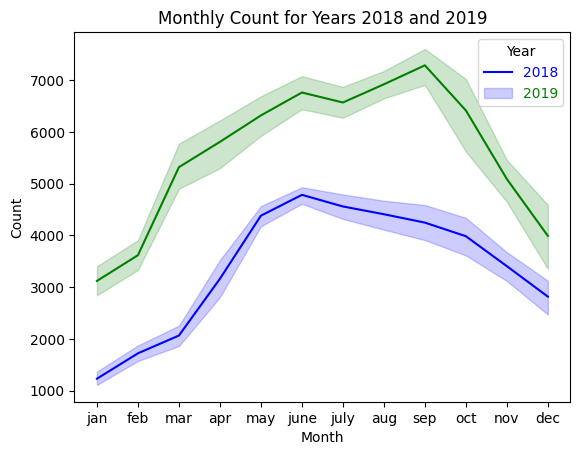

In [119]:
# Line graph will that show the count vs month for year 2018 and 2019.

# Define line colors
line_colors = ['blue', 'green']  # Example colors for 2018 and 2019 lines
legend_colors = ['blue', 'green']  # Colors for the legend

sns.lineplot(x="month", y="cnt", data=bike, hue="year", palette=line_colors)

legend = plt.legend(title='Year', labels=['2018', '2019'])
for i, text in enumerate(legend.get_texts()):
    plt.setp(text, color=legend_colors[i])

# Adding titles and labels
plt.title("Monthly Count for Years 2018 and 2019")
plt.xlabel("Month")
plt.ylabel("Count")

# Displaying the plot
plt.show()


 Insight:
 1. From Line Graph we can see that target Variable cnt has increased from 2018 to 2019.
 2. Demand for bike is high between may to oct for year 2018 and 2019.




In [120]:
num_cols = ['temp', 'atemp', 'humidity', 'windspeed']


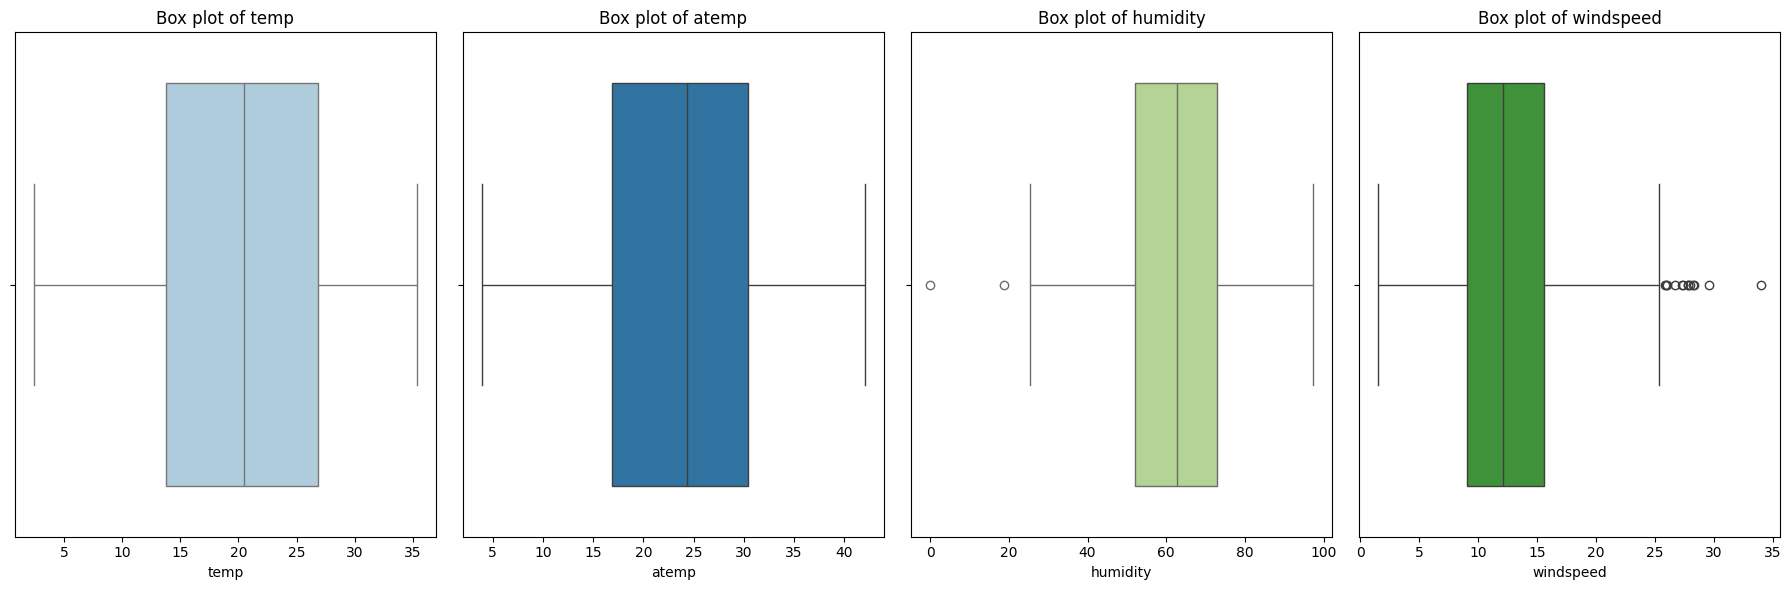

In [121]:
import math

def create_boxplots_subplots(df, column_list):
    """
    Creates subplots of box plots with up to four in each row for the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame.
    column_list (list): A list of column names to be plotted.

    Returns:
    None
    """
    # Calculate the number of rows and columns needed for subplots
    num_columns = len(column_list)
    num_cols_per_row = min(4, num_columns)  # Maximum of 4 columns per row
    num_rows = math.ceil(num_columns / num_cols_per_row)
    num_subplots = num_rows * num_cols_per_row

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(18, 6*num_rows))
    
    # Flatten axes if needed
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Define a custom color palette
    custom_palette = sns.color_palette("Paired")

    # Plot each column in a box plot
    for i, col in enumerate(column_list):
        row_idx = i // num_cols_per_row
        col_idx = i % num_cols_per_row
        sns.boxplot(x=df[col], ax=axes[row_idx, col_idx], color=custom_palette[i % len(custom_palette)])
        axes[row_idx, col_idx].set_title(f'Box plot of {col}')
        axes[row_idx, col_idx].set_xlabel(col)
    
    # Remove empty subplots
    if num_subplots > num_columns:
        for i in range(num_columns, num_subplots):
            row_idx = i // num_cols_per_row
            col_idx = i % num_cols_per_row
            fig.delaxes(axes[row_idx, col_idx])

    plt.tight_layout()
    plt.show()

# Example usage with a sample DataFrame
# Assuming 'bike_train' is your DataFrame
create_boxplots_subplots(bike, num_cols)


In [122]:
# Inferences:
# 1. From Line Graph we can see that target Variable cnt has increased from 2018 to 2019.
# 2. Demand for bike is high between may to oct for year 2018 and 2019.
# 3. From Boxchart we can also see that there is no outliers present.

Insight

There are few outliers in windspeed and humidity features lets replace them with upper and lower bound values. 

In [123]:
def replace_outliers_with_cap(df_name, column_list):
  """
  Replaces outliers in specified columns of the DataFrame with capped values.

  Parameters:
    df_name (pd.DataFrame): The DataFrame.
    column_list (list): A list of column names in which outliers are to be replaced.

  Returns:
    pd.DataFrame: The DataFrame with capped outliers.
  """
  for column in column_list:
    # Calculate Q1, Q3, and IQR
    Q1 = df_name[column].quantile(0.25)
    Q3 = df_name[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers using lower and upper bounds
    df_name.loc[df_name[column] < lower_bound, column] = lower_bound
    df_name.loc[df_name[column] > upper_bound, column] = upper_bound

  return df_name


In [124]:
replace_outliers_with_cap(bike,num_cols)



,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,0,jan,0,mon,1,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,tue,1,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,1,dec,0,fri,1,Mist,10.420847,11.33210,65.2917,23.458911,2114
726,spring,1,dec,0,sat,0,Mist,10.386653,12.75230,59.0000,10.416557,3095
727,spring,1,dec,0,sun,0,Mist,10.386653,12.12000,75.2917,8.333661,1341
728,spring,1,dec,0,mon,1,Clear,10.489153,11.58500,48.3333,23.500518,1796


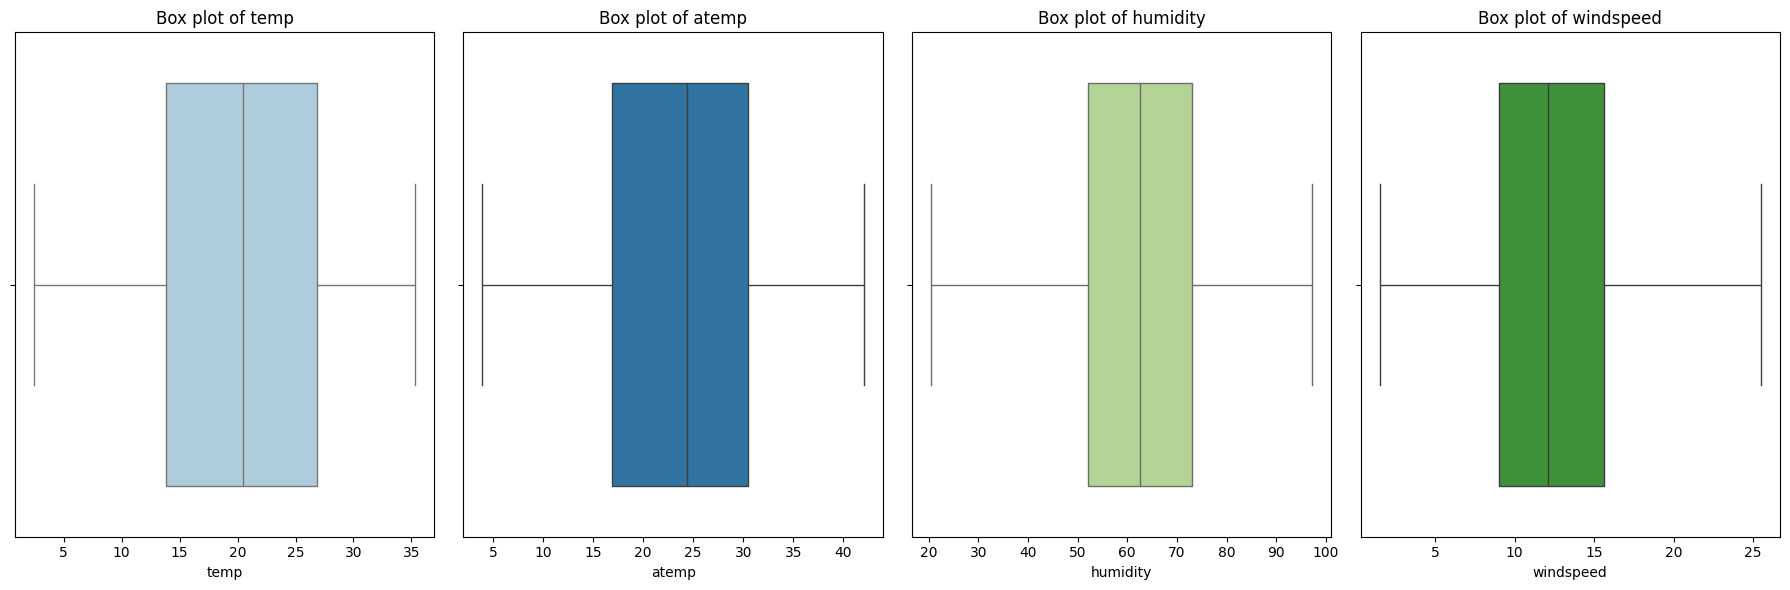

In [125]:
create_boxplots_subplots(bike, num_cols)


Insight

Now you can see there are no outliers.

 ## Bivariate Analysis of Categrorical columns with repect to ```Target Column (cnt)``` and ```Year```. 

In [126]:
def plot_cat_columns(cat_columns, data):
    num_columns = len(cat_columns)
    num_rows = num_columns
    num_cols = 2
    
    # Set up the figure and axes
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    
    # Iterate over categorical columns
    for i, column in enumerate(cat_columns):
        # Calculate mean values for each category and sort in descending order
        mean_values = data.groupby(column)['cnt'].mean().sort_values(ascending=False)
        
        # Plot without hue
        plt.subplot(num_rows, num_cols, i*2+1)
        sns.barplot(x=mean_values.index, y=mean_values.values, palette='Set1')
        plt.title(f'Bar Plot of {column} vs cnt')
        plt.xlabel(column)
        plt.ylabel('cnt')
        
        # Plot with hue='year'
        plt.subplot(num_rows, num_cols, i*2+2)
        sns.barplot(x=column, y='cnt', data=data, hue='year', palette='Set1', order=mean_values.index)
        plt.title(f'Bar Plot of {column} vs cnt (wrt Year)')
        plt.xlabel(column)
        handles, labels = plt.gca().get_legend_handles_labels()
        custom_handles = [plt.Line2D([0], [0], color='red', lw=4), plt.Line2D([0], [0], color='blue', lw=4)]
        plt.legend(custom_handles, ['2018', '2019'])

    plt.tight_layout()




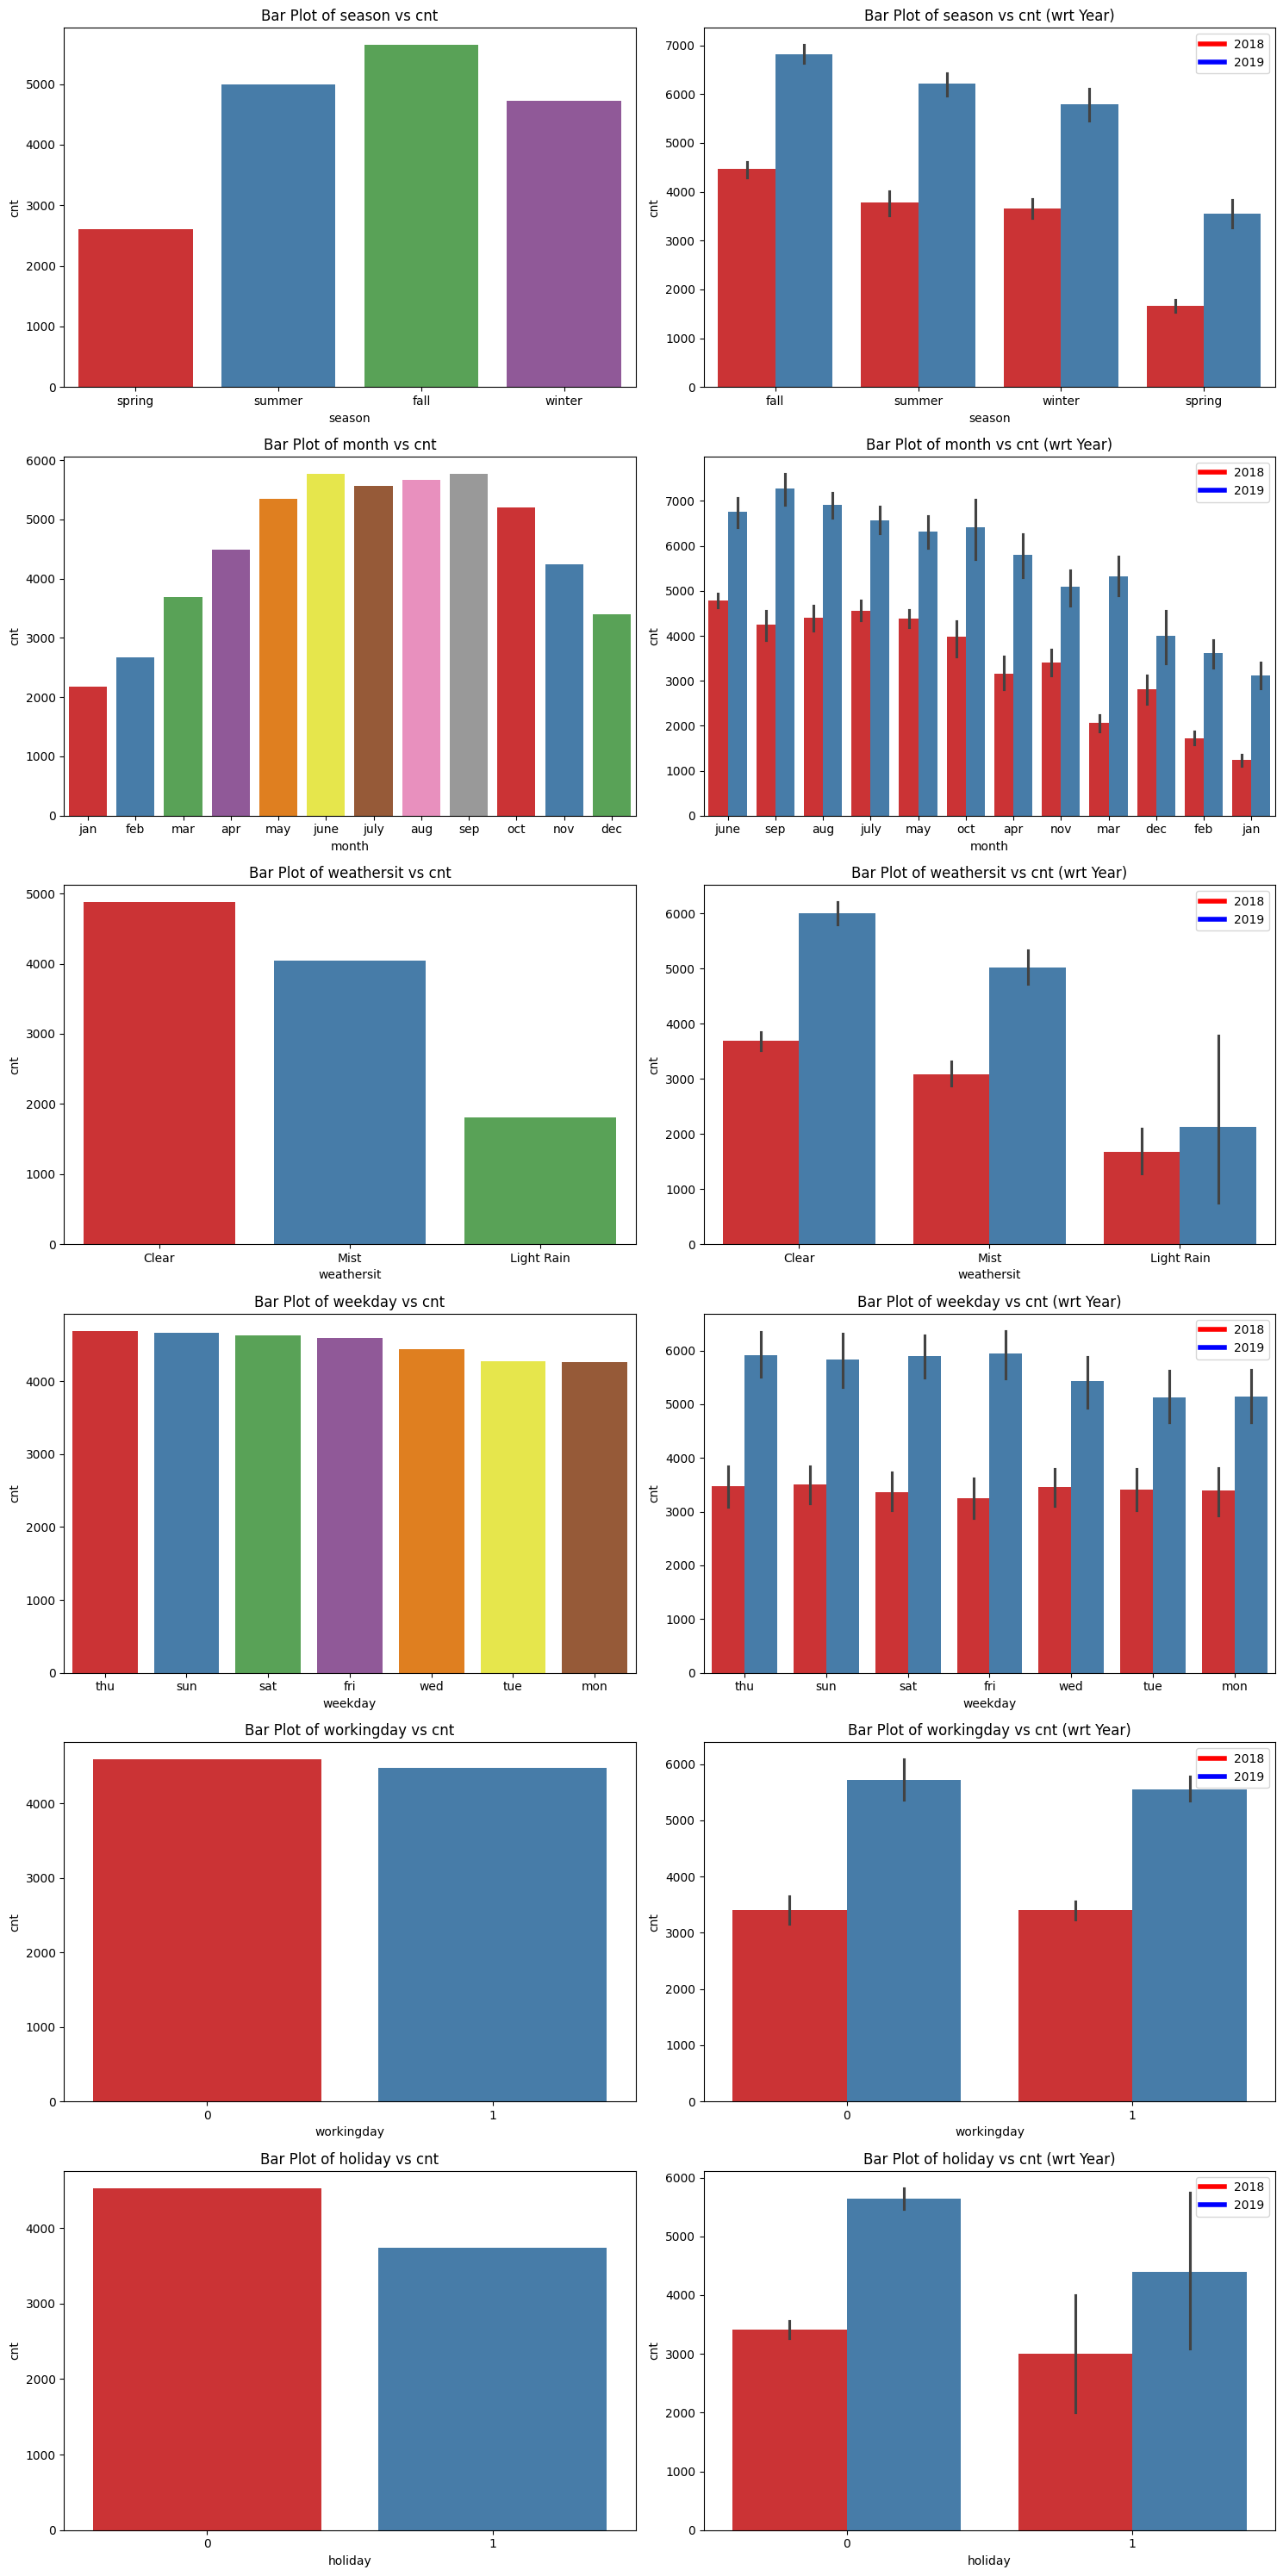

In [127]:
plot_cat_columns(['season', 'month', 'weathersit', 'weekday',"workingday","holiday"], bike)

Insights

1. Over all count of total rental bikes have increased from 2018 to 2019
2. Fall season is the most favourable time when people are renting bikes for both the years with spring season the least. 
3. June, September, August Month are the months with highest rentals with December, Jan and Feb with the least. 
4. When the weather is clear people are renting the bikes highest with nill during heavy rain and very less during light rain
5. Thursay to Sunday people are renting the bikes frequently but the number drops between monday to wednesday
6. Intrestingly the count of total rental come down for weekends and holiday in 2019 compared to 2018.

In [128]:
bike.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,0,jan,0,mon,1,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,tue,1,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


# Multivariate Analysis

In [129]:
numeric_columns = [col for col in bike.columns if bike[col].dtype in ['int64', "int32",'float64']]


In [130]:
numeric_columns

['year',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'cnt']

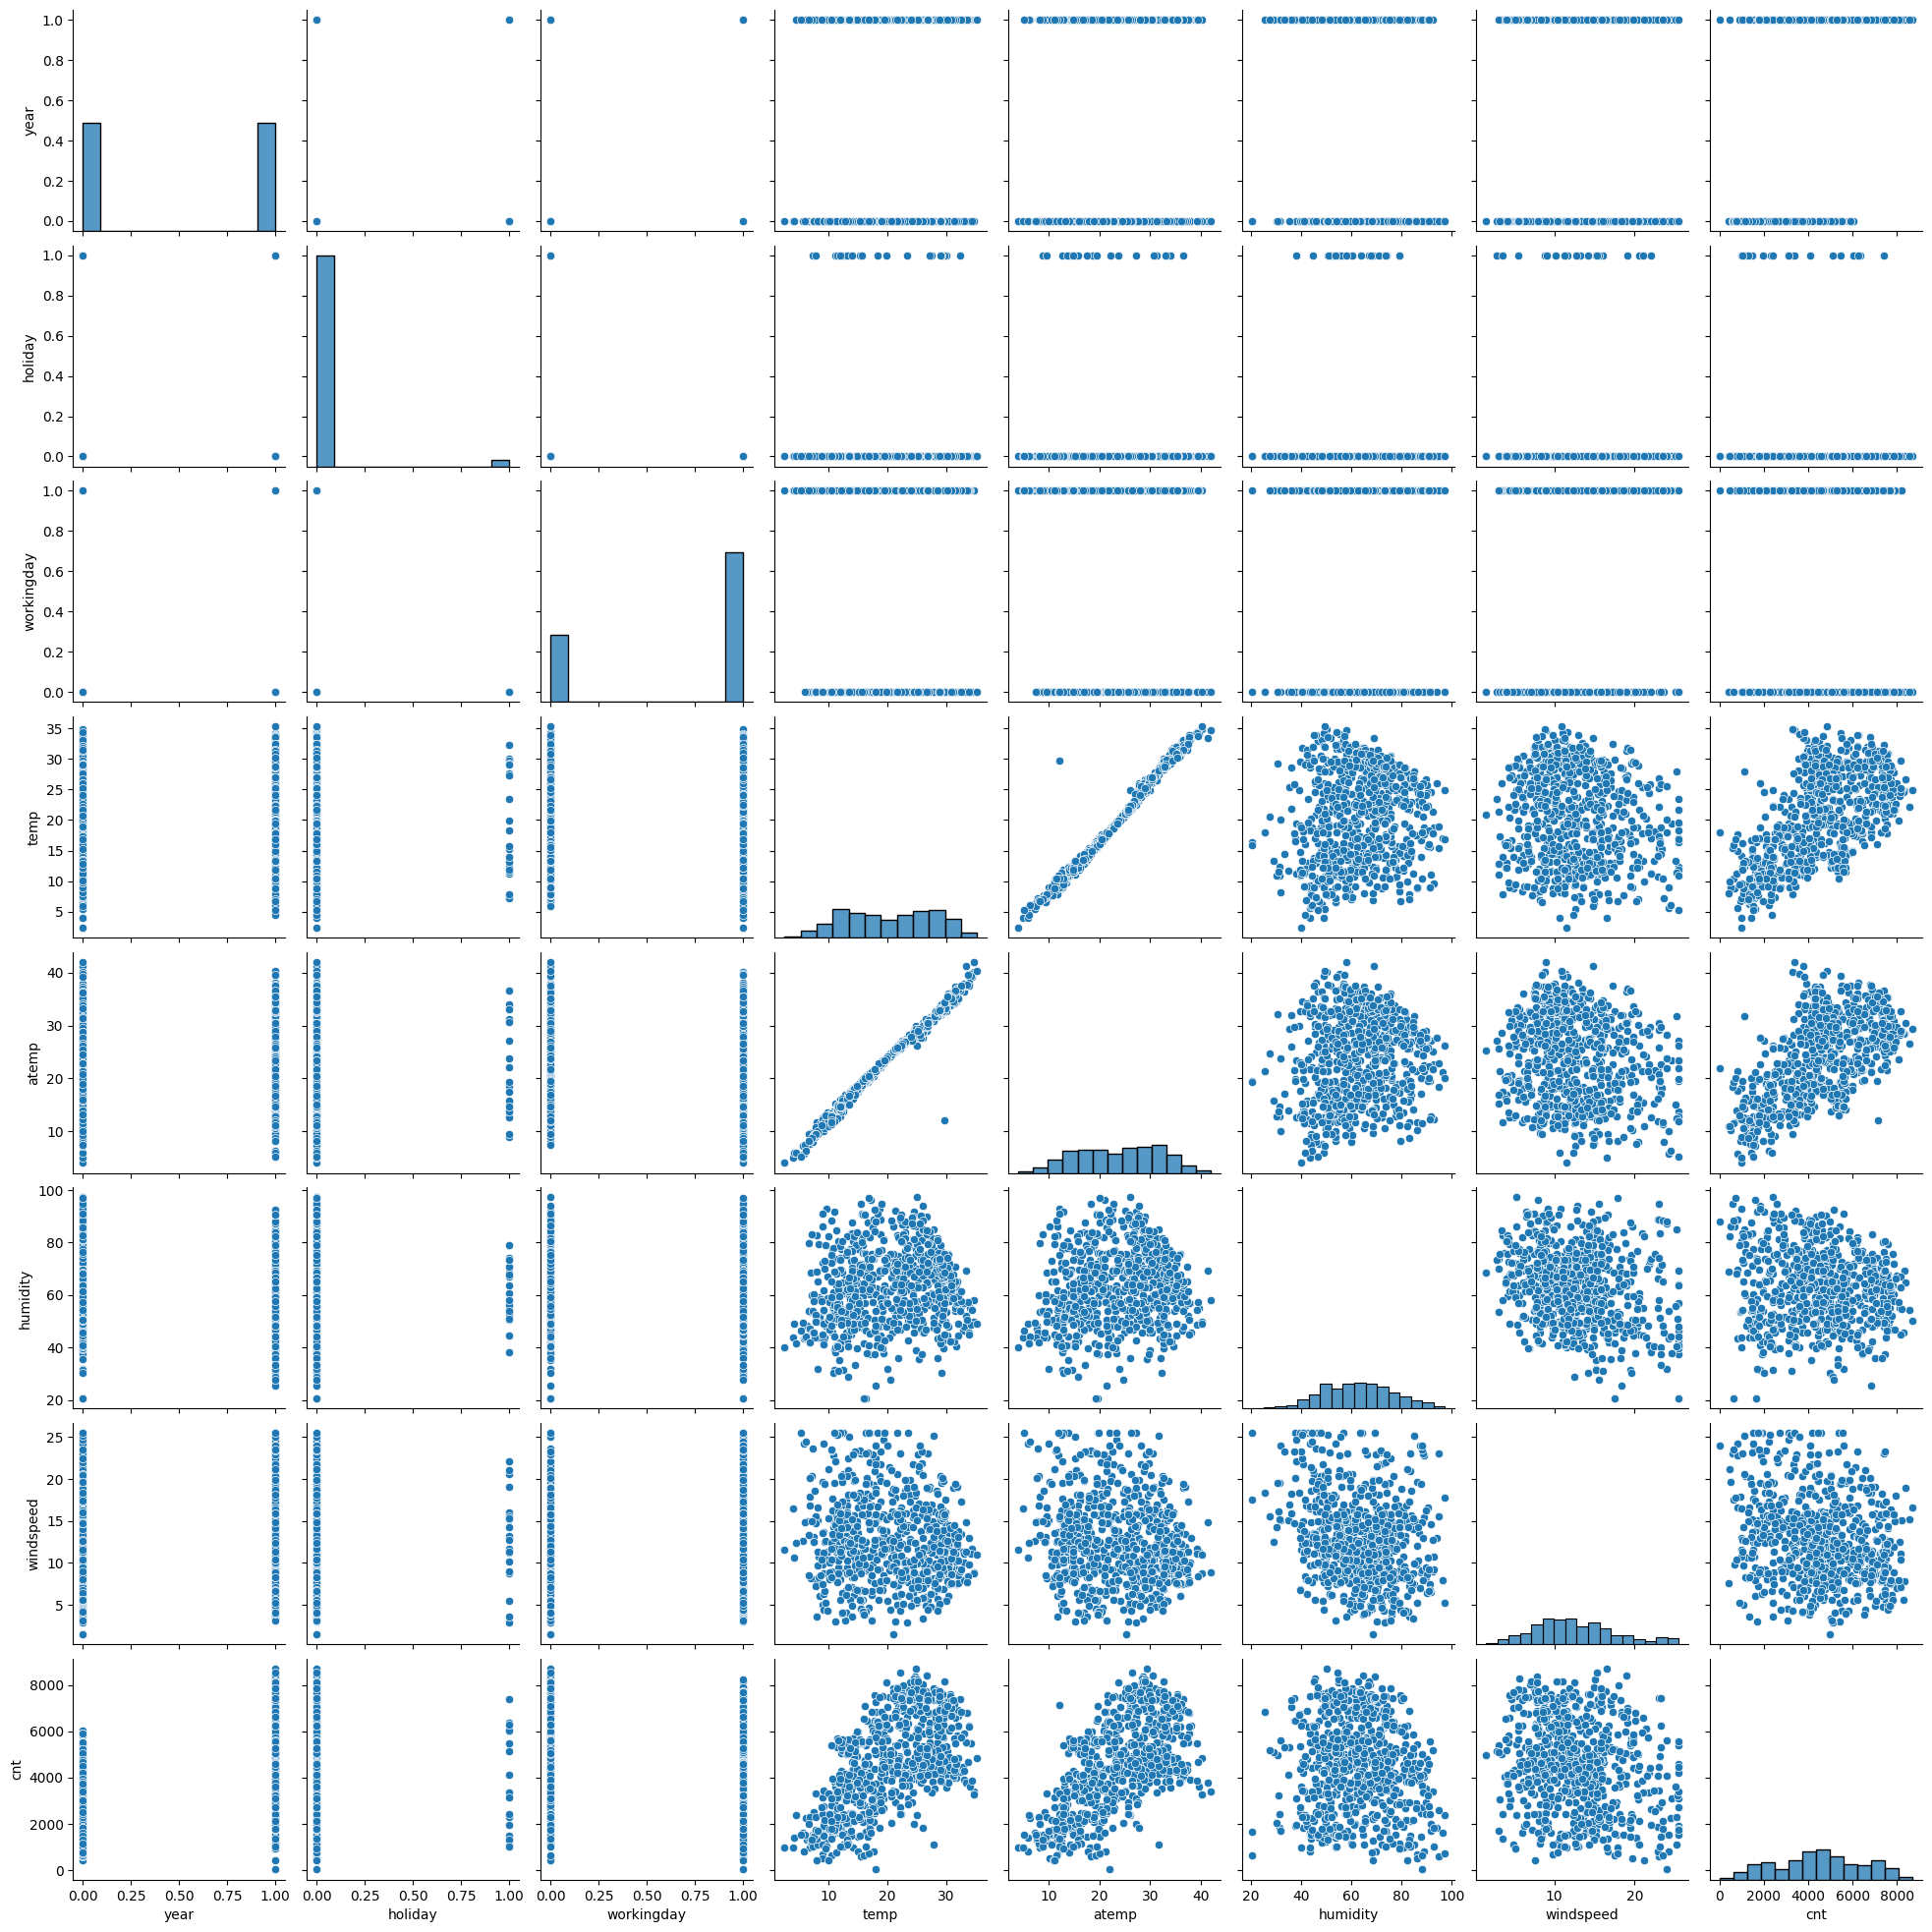

In [131]:
# Create a pair plot to check the correlations between the dependendent columns and with respect to Target (cnt) column.

sns.pairplot(data=bike,vars=numeric_columns)
plt.show()

Top 5 correlations with 'cnt':
           Correlation with cnt
atemp                  0.630685
temp                   0.627044
year                   0.569728
windspeed              0.234234
humidity               0.103566
Top 5 correlations between other features:
    Feature1    Feature2  Correlation
31     atemp        temp     0.991696
9    holiday  workingday     0.257009
41  humidity   windspeed     0.241170
34     atemp   windspeed     0.183176
27      temp   windspeed     0.157152


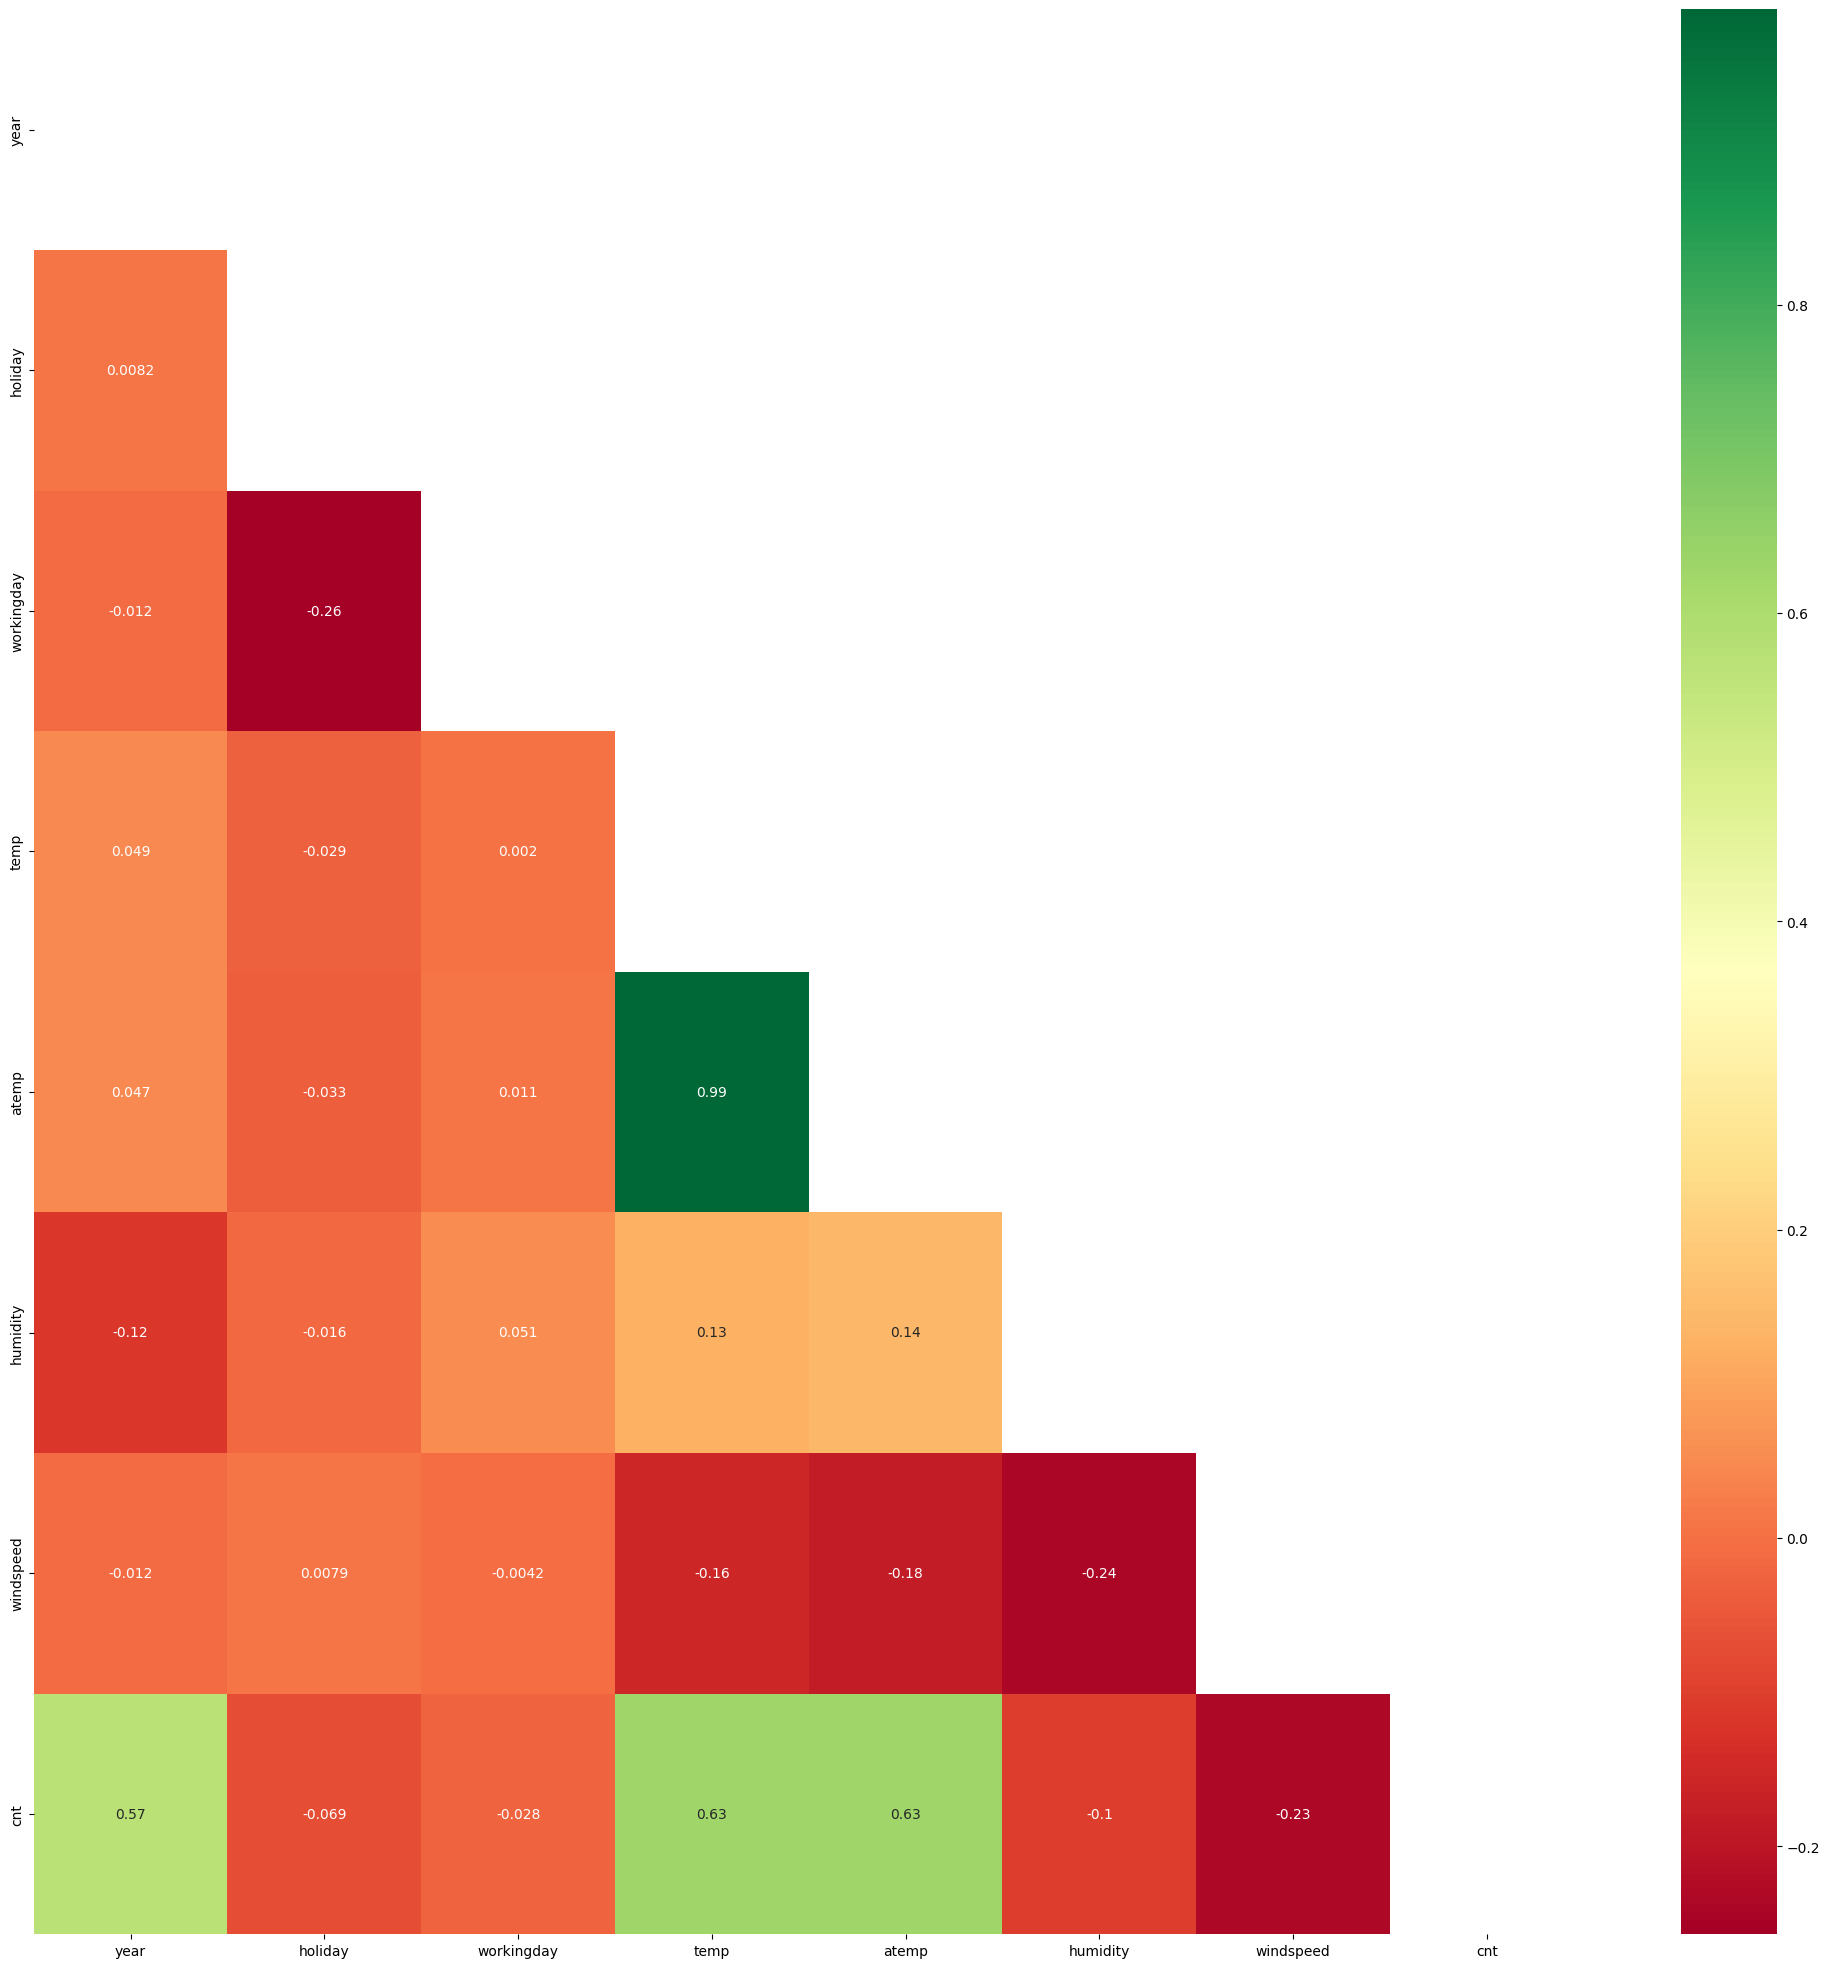

In [132]:
corr_Defaulter = bike[numeric_columns].corr()

# Extract correlations with 'cnt'
corr_cnt = corr_Defaulter[['cnt']].drop('cnt')
corr_cnt = corr_cnt.rename(columns={'cnt': 'Correlation with cnt'})

# Take absolute values of correlations
corr_cnt["Correlation with cnt"] = corr_cnt["Correlation with cnt"].abs()

# Sort values by correlation
corr_cnt = corr_cnt.sort_values(by='Correlation with cnt', ascending=False)

# Get top 5 correlations with 'cnt'
top_corr_with_cnt = corr_cnt.head(5)

print("Top 5 correlations with 'cnt':")
print(top_corr_with_cnt)

# Extract correlations between other features, excluding 'cnt'
corr_others = corr_Defaulter.drop('cnt').drop('cnt', axis=1)

# Convert the correlation matrix to a long format DataFrame
corr_others_unstacked = corr_others.unstack().reset_index()
corr_others_unstacked.columns = ['Feature1', 'Feature2', 'Correlation']

# Drop duplicate pairs and NaN values
corr_others_unstacked = corr_others_unstacked[corr_others_unstacked['Feature1'] < corr_others_unstacked['Feature2']]

# Take absolute values of correlations
corr_others_unstacked["Correlation"] = corr_others_unstacked["Correlation"].abs()

# Sort values by correlation
corr_others_unstacked = corr_others_unstacked.sort_values(by='Correlation', ascending=False)

# Get top 5 correlations between other features
top_corr_others = corr_others_unstacked.head(5)

print("Top 5 correlations between other features:")
print(top_corr_others)

# Plot the heatmap considering only numeric columns
plt.figure(figsize=(25, 25))
matrix = np.triu(bike[numeric_columns].corr())
sns.heatmap(bike[numeric_columns].corr(), annot=True, cmap="RdYlGn", mask=matrix)
plt.show()

Insight:
- `cnt` is strongly corelated with `atemp`, `temp`, `year`
-   `atemp`, `temp` are highly correlated           


In [133]:
bike.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,0,jan,0,mon,1,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,tue,1,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [134]:
bike.dtypes

season        category
year             int64
month         category
holiday          int64
weekday         object
workingday       int64
weathersit    category
temp           float64
atemp          float64
humidity       float64
windspeed      float64
cnt              int64
dtype: object

## Step 3: Data Preparation

In [135]:
def create_dummy_variables(data, columns):
    """
    Create dummy variables for the specified categorical columns in the DataFrame and drop the original columns.
    
    Parameters:
    data (DataFrame): The input DataFrame.
    columns (list): List of column names for which dummy variables should be created.
    
    Returns:
    DataFrame: The DataFrame with dummy variables created and original columns dropped.
    """
    # Create dummy variables for each column in the list
    dummy_variables = pd.get_dummies(data[columns], drop_first=True, dtype=int, prefix='', prefix_sep='')
    
    # Concatenate dummy variables with the DataFrame
    data = pd.concat([data, dummy_variables], axis=1)
    
    # Drop original categorical columns from the DataFrame
    data.drop(columns, axis=1, inplace=True)
    
    return data


In [136]:
bike = create_dummy_variables(bike, ['month', 'weekday', 'weathersit', 'season'])


In [137]:
bike.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,feb,mar,...,sat,sun,thu,tue,wed,Mist,Light Rain,summer,fall,winter
0,0,0,1,14.110847,18.18125,80.5833,10.749882,985,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,1,14.902598,17.68695,69.6087,16.652113,801,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
bike.columns

Index(['year', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'cnt', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug',
       'sep', 'oct', 'nov', 'dec', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed',
       'Mist', 'Light Rain', 'summer', 'fall', 'winter'],
      dtype='object')

In [139]:
bike.shape

(730, 30)

In [140]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   atemp       730 non-null    float64
 5   humidity    730 non-null    float64
 6   windspeed   730 non-null    float64
 7   cnt         730 non-null    int64  
 8   feb         730 non-null    int32  
 9   mar         730 non-null    int32  
 10  apr         730 non-null    int32  
 11  may         730 non-null    int32  
 12  june        730 non-null    int32  
 13  july        730 non-null    int32  
 14  aug         730 non-null    int32  
 15  sep         730 non-null    int32  
 16  oct         730 non-null    int32  
 17  nov         730 non-null    int32  
 18  dec         730 non-null    int32  
 19  mon         730 non-null    i

In [141]:
bike.shape

(730, 30)

## Step 4: Splitting the Data into Training and Testing Sets

In [142]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
bike_train, bike_test = train_test_split(bike, train_size = 0.7, random_state = 100)

In [143]:
bike_train.shape

(510, 30)

In [144]:
bike_test.shape

(220, 30)

### Rescaling the Features 



In [145]:
# Apply scaler() to all the columns except the '1-0' and 'dummy' variables


def non_categorical_non_binary_columns(data):
    non_cat_non_binary_columns = []
    for column in data.columns:
        if data[column].dtype in ["int32",'int64', 'float64']:  # Check if the column is numerical
            unique_values = data[column].unique()
            if len(unique_values) > 2 or not all(value in [0, 1] for value in unique_values):  # Check if unique values are not only 0 and 1
                non_cat_non_binary_columns.append(column)
    return non_cat_non_binary_columns

# Usage
num_vars = non_categorical_non_binary_columns(bike)
print(num_vars)



['temp', 'atemp', 'humidity', 'windspeed', 'cnt']


In [146]:
bike.columns

Index(['year', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'cnt', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug',
       'sep', 'oct', 'nov', 'dec', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed',
       'Mist', 'Light Rain', 'summer', 'fall', 'winter'],
      dtype='object')

In [147]:
scaler = MinMaxScaler()

bike_train[num_vars] = scaler.fit_transform(bike_train[num_vars])

In [148]:
bike_train.columns

Index(['year', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'cnt', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug',
       'sep', 'oct', 'nov', 'dec', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed',
       'Mist', 'Light Rain', 'summer', 'fall', 'winter'],
      dtype='object')

In [149]:
bike_train.describe()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,feb,mar,...,sat,sun,thu,tue,wed,Mist,Light Rain,summer,fall,winter
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.711765,0.537440,0.513156,0.557348,0.438893,0.513499,0.066667,0.098039,...,0.129412,0.137255,0.143137,0.152941,0.135294,0.345098,0.029412,0.247059,0.262745,0.247059
std,0.500429,0.157763,0.453386,0.225858,0.212410,0.182829,0.226881,0.224421,0.249689,0.297660,...,0.335985,0.344454,0.350557,0.360284,0.342373,0.475867,0.169124,0.431725,0.440557,0.431725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.414959,0.273856,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.560879,0.408027,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.689104,0.569834,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


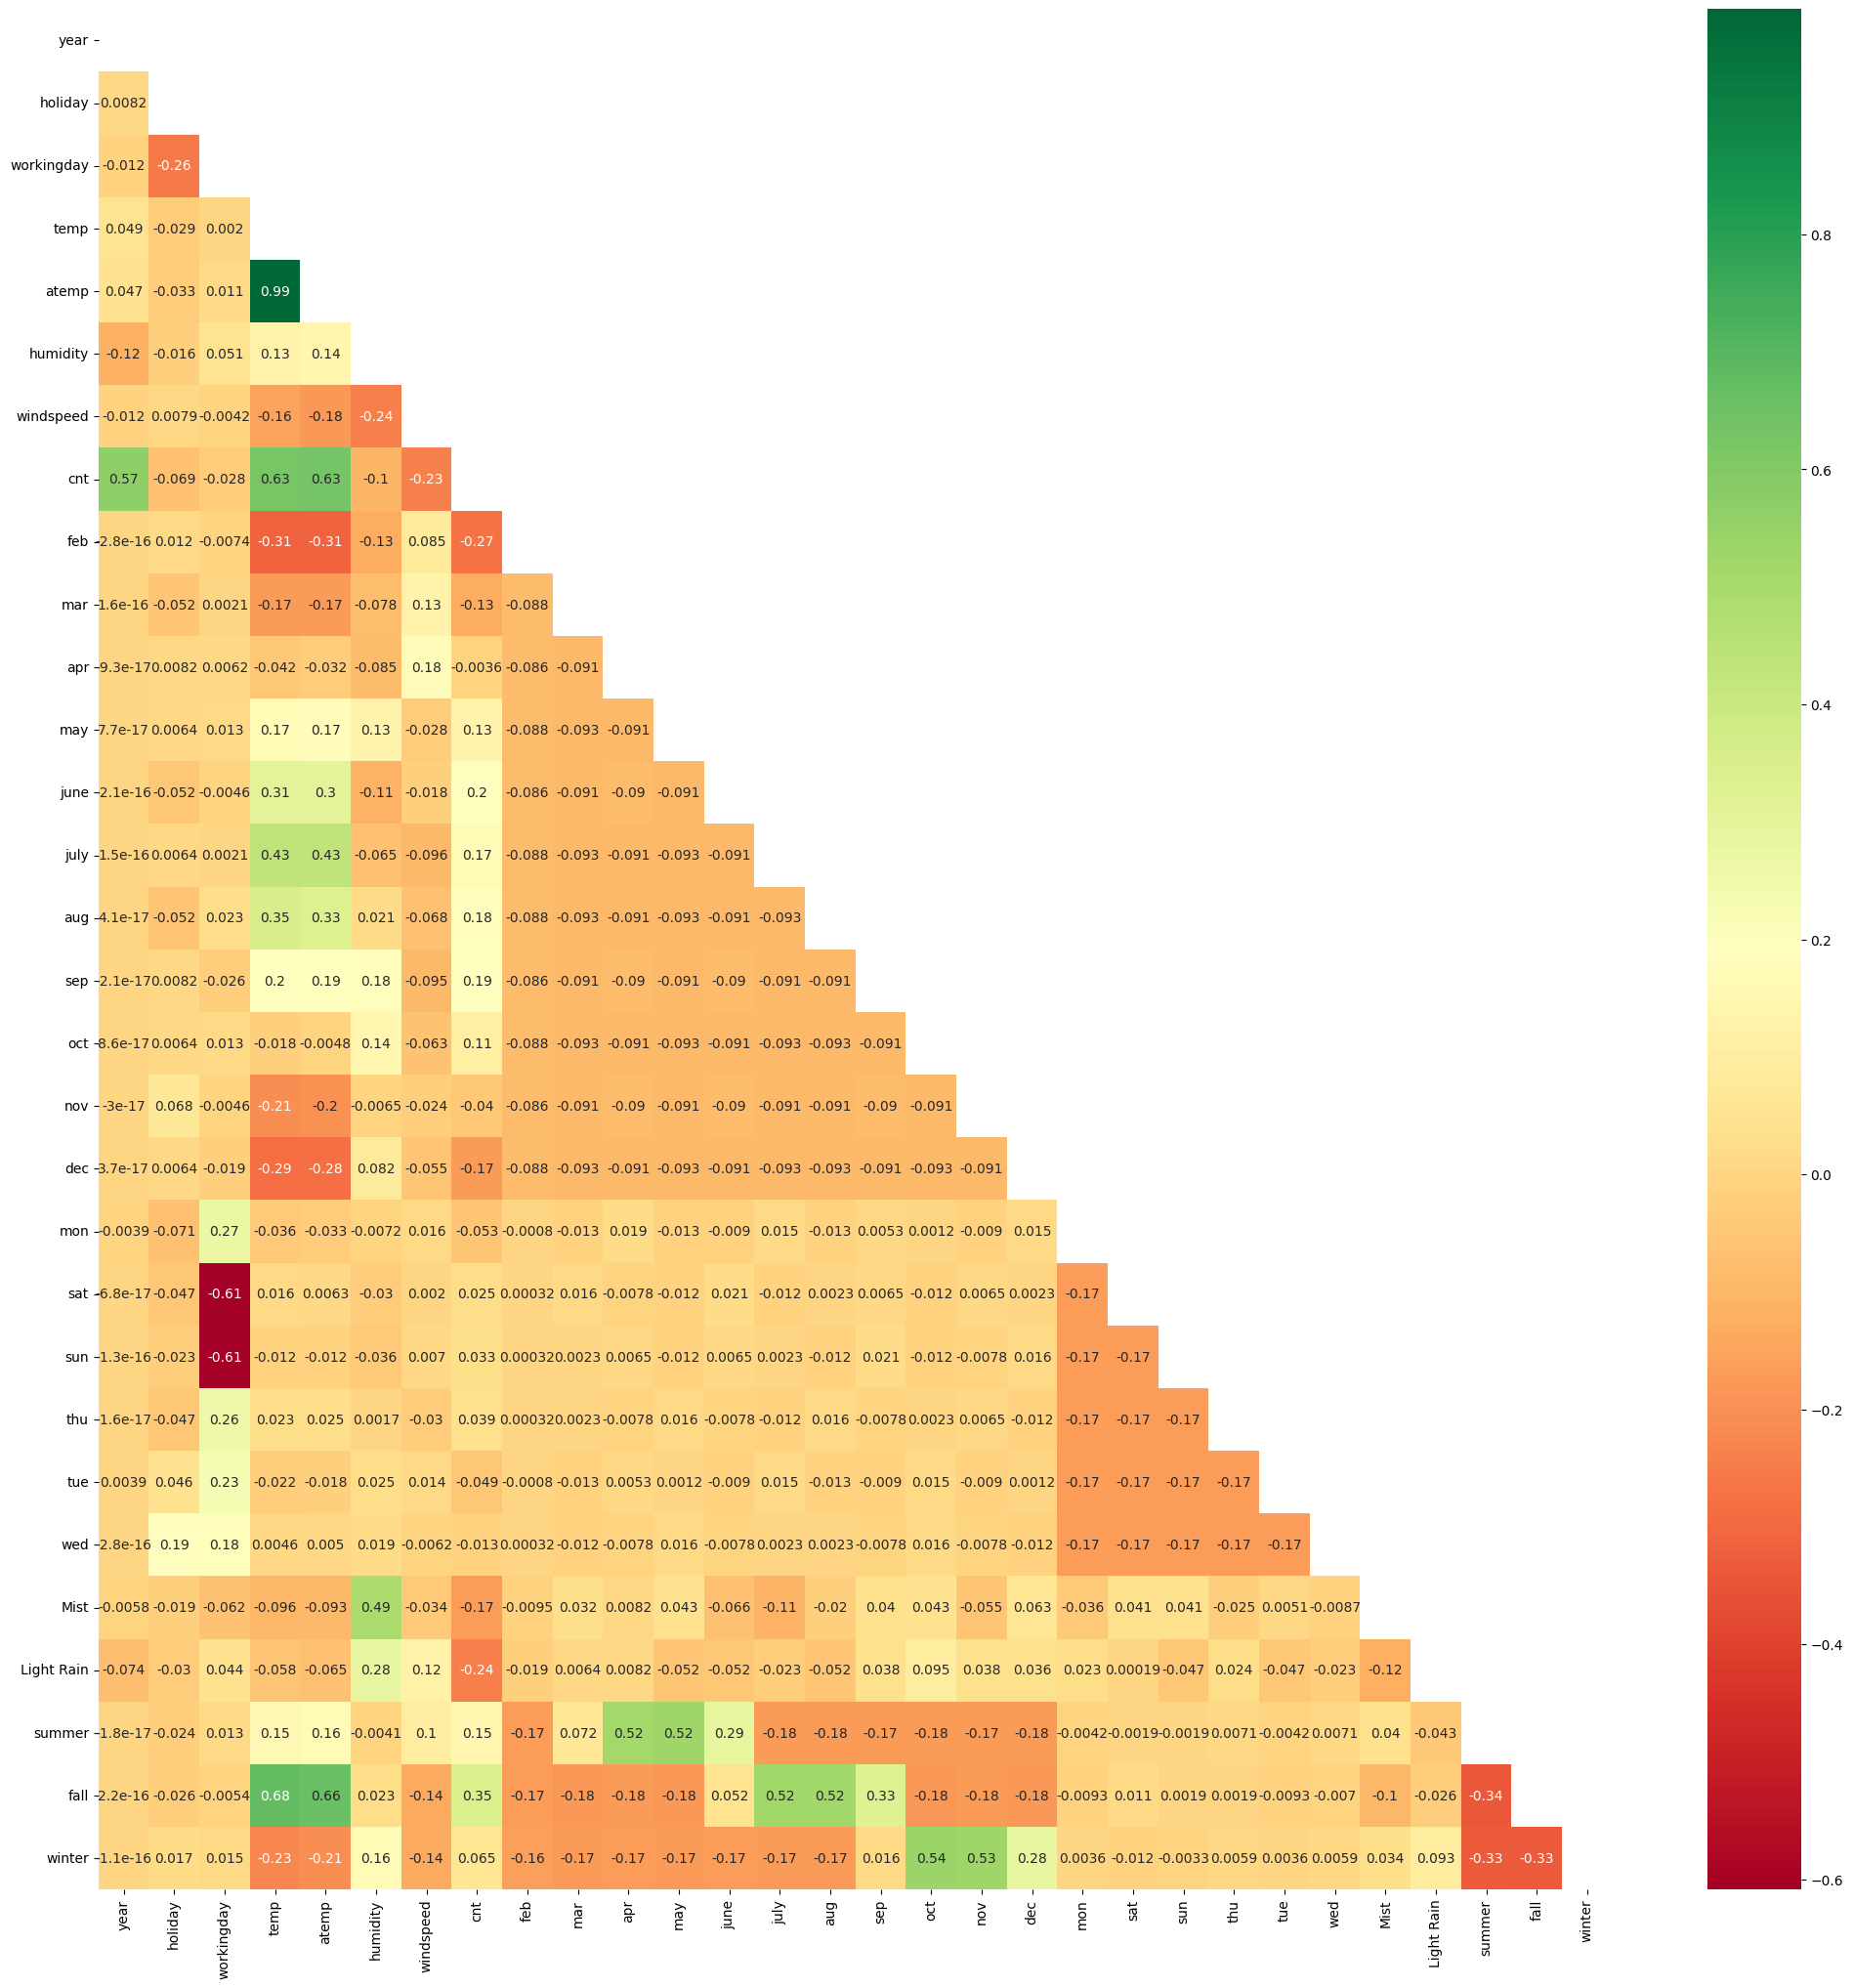

Top 5 correlations where 'cnt' is feature 2:
atemp    0.630685
temp     0.627044
year     0.569728
fall     0.345908
june     0.195568
Name: cnt, dtype: float64

Top 10 correlations excluding 'cnt' as either feature 1 or feature 2:
       Feature1 Feature2  Correlation
94         temp    atemp     0.991696
118        temp     fall     0.678283
148       atemp     fall     0.655757
80   workingday      sat    -0.608682
81   workingday      sun    -0.608682
509         oct   winter     0.536497
539         nov   winter     0.526984
357         may   summer     0.524801
418        july     fall     0.517283
448         aug     fall     0.517283


In [150]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(25, 25))
corr_matrix = bike.corr()
matrix = np.triu(corr_matrix)  # Upper triangular mask
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn", mask=matrix)
plt.show()

# Print top 5 correlations where 'cnt' is feature 2
top_correlations_cnt = corr_matrix['cnt'].sort_values(ascending=False).iloc[1:6]
print("Top 5 correlations where 'cnt' is feature 2:")
print(top_correlations_cnt)

# Print top 10 correlations excluding 'cnt' as either feature 1 or feature 2
corr_df = corr_matrix.unstack().reset_index()
corr_df.columns = ['Feature1', 'Feature2', 'Correlation']

# Filter out rows where feature 1 and feature 2 are the same
corr_df_filtered = corr_df[corr_df['Feature1'] != corr_df['Feature2']]

# Exclude 'cnt'
corr_df_filtered = corr_df_filtered[(corr_df_filtered['Feature1'] != 'cnt') & (corr_df_filtered['Feature2'] != 'cnt')]

# Create a set to keep track of processed pairs
processed_pairs = set()

# Iterate through the filtered dataframe to check for pairs already processed
filtered_correlations = []
for index, row in corr_df_filtered.iterrows():
    pair = frozenset({row['Feature1'], row['Feature2']})
    if pair not in processed_pairs:
        filtered_correlations.append(row)
        processed_pairs.add(pair)

# Convert the filtered correlations back to a DataFrame
filtered_correlations_df = pd.DataFrame(filtered_correlations)

# Compute absolute correlation values
filtered_correlations_df['Abs_Correlation'] = filtered_correlations_df['Correlation'].abs()

# Get top 10 correlations
top_correlations_without_cnt = filtered_correlations_df.sort_values(by='Abs_Correlation', ascending=False).head(10)
print("\nTop 10 correlations excluding 'cnt' as either feature 1 or feature 2:")
print(top_correlations_without_cnt[['Feature1', 'Feature2', 'Correlation']])


 Insights based on the correlations:

1. Temperature-related variables ('temp' and 'atemp') have a strong positive correlation with bike count ('cnt'). This indicates that higher temperatures lead to increased bike rentals.
2. The fall season ('fall') also shows a strong positive correlation with bike count ('cnt'), suggesting that bike rentals tend to be higher during autumn.
3. Weekend days ('sat' and 'sun') exhibit a strong negative correlation with working days ('workingday'). This implies that bike rentals are higher on weekends compared to weekdays.
4. Certain months ('may', 'july', 'aug', 'oct', 'nov') show moderate positive correlations with seasons ('summer', 'fall', 'winter'), indicating transitions between seasons. This suggests that bike rentals may vary based on seasonal changes.



### Dividing into X and Y sets for the model building

In [151]:
y_train = bike_train.pop('cnt')
X_train = bike_train

## Step 5: Building a linear model

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

In [152]:
X_train.shape

(510, 29)

In [153]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [154]:

# Assuming X_train and y_train are already defined
lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=15)  # running RFE
rfe = rfe.fit(X_train, y_train)

# Get the selected feature indices
selected_features = rfe.support_

# Get the ranking of the features
feature_ranking = rfe.ranking_



In [155]:
#List of variables selected in top 15 list

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 5),
 ('temp', True, 1),
 ('atemp', False, 4),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('feb', False, 10),
 ('mar', True, 1),
 ('apr', False, 3),
 ('may', True, 1),
 ('june', False, 2),
 ('july', False, 11),
 ('aug', True, 1),
 ('sep', True, 1),
 ('oct', True, 1),
 ('nov', False, 12),
 ('dec', False, 13),
 ('mon', False, 9),
 ('sat', False, 6),
 ('sun', False, 7),
 ('thu', False, 15),
 ('tue', False, 8),
 ('wed', False, 14),
 ('Mist', True, 1),
 ('Light Rain', True, 1),
 ('summer', True, 1),
 ('fall', True, 1),
 ('winter', True, 1)]

In [156]:
col = X_train.columns[rfe.support_]
col

Index(['year', 'holiday', 'temp', 'humidity', 'windspeed', 'mar', 'may', 'aug',
       'sep', 'oct', 'Mist', 'Light Rain', 'summer', 'fall', 'winter'],
      dtype='object')

In [157]:
X_train.columns[~rfe.support_]

Index(['workingday', 'atemp', 'feb', 'apr', 'june', 'july', 'nov', 'dec',
       'mon', 'sat', 'sun', 'thu', 'tue', 'wed'],
      dtype='object')

In [158]:
# Generic function to calculate VIF of variables

def calculateVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif 

In [159]:
# dataframe with RFE selected variables

X_train_rfe = X_train[col]

In [160]:
# calculate VIF

calculateVIF(X_train_rfe)

,Features,VIF
2,temp,23.22
3,humidity,12.43
13,fall,8.77
12,summer,3.76
4,windspeed,3.65
14,winter,3.07
10,Mist,2.33
0,year,2.04
7,aug,1.85
6,may,1.68


## Step 5: Building a linear model

##### Building 1st Linear Regression Model

In [161]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm_1 = sm.add_constant(X_train_rfe)


In [162]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [163]:
lr_1 = sm.OLS(y_train,X_train_lm_1).fit()


In [164]:
#Let's see the summary of our linear model
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     178.9
Date:                Tue, 04 Jun 2024   Prob (F-statistic):          1.50e-188
Time:                        13:04:24   Log-Likelihood:                 513.55
No. Observations:                 510   AIC:                            -995.1
Df Residuals:                     494   BIC:                            -927.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2013      0.022      9.161      0.0

Since ```temp ```has p_value>0.05 we are going to drop this column `

In [165]:
X_train_new = X_train_rfe.drop(['fall'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
3,humidity,11.90
2,temp,9.08
4,windspeed,3.56
10,Mist,2.31
12,summer,2.31
13,winter,2.28
0,year,2.02
6,may,1.64
7,aug,1.62
9,oct,1.59


##### Building 2nd linear regression model


In [166]:

X_train_lm_2 = sm.add_constant(X_train_new)
lr_2 = sm.OLS(y_train,X_train_lm_2).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.5
Date:                Tue, 04 Jun 2024   Prob (F-statistic):          6.10e-189
Time:                        13:04:57   Log-Likelihood:                 511.74
No. Observations:                 510   AIC:                            -993.5
Df Residuals:                     495   BIC:                            -930.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1989      0.022      9.046      0.0

Since ```atemp ```has VIF>10 we are going to drop this column `

In [167]:
X_train_new = X_train_new.drop(['may'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
3,humidity,11.71
2,temp,9.07
4,windspeed,3.51
9,Mist,2.31
12,winter,2.27
0,year,2.01
11,summer,1.84
6,aug,1.61
8,oct,1.59
7,sep,1.35


##### Building 3rd linear regression model


In [168]:
X_train_lm_3 = sm.add_constant(X_train_new)
lr_3 = sm.OLS(y_train,X_train_lm_3).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     204.7
Date:                Tue, 04 Jun 2024   Prob (F-statistic):          9.61e-190
Time:                        13:05:30   Log-Likelihood:                 510.88
No. Observations:                 510   AIC:                            -993.8
Df Residuals:                     496   BIC:                            -934.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1961      0.022      8.956      0.0

Since ```humidity ```has p_value>0.05 we are going to drop this column `

In [169]:
X_train_new = X_train_new.drop(['mar'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
3,humidity,11.52
2,temp,8.99
4,windspeed,3.36
8,Mist,2.31
11,winter,2.20
0,year,2.01
10,summer,1.84
5,aug,1.60
7,oct,1.59
6,sep,1.34


##### Building 4rth linear regression model


In [170]:
X_train_lm_4 = sm.add_constant(X_train_new)
lr_4 = sm.OLS(y_train,X_train_lm_4).fit()
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     220.7
Date:                Tue, 04 Jun 2024   Prob (F-statistic):          2.64e-190
Time:                        13:06:08   Log-Likelihood:                 509.41
No. Observations:                 510   AIC:                            -992.8
Df Residuals:                     497   BIC:                            -937.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2023      0.022      9.345      0.0

Since ```july ```has p_value>0.05 we are going to drop this column `

In [171]:
X_train_new = X_train_new.drop(['oct'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
3,humidity,11.50
2,temp,8.83
4,windspeed,3.35
7,Mist,2.31
0,year,2.00
9,summer,1.83
10,winter,1.72
5,aug,1.58
6,sep,1.31
8,Light Rain,1.22


##### Building 5th  linear regression model


In [172]:
X_train_lm_5 = sm.add_constant(X_train_new)
lr_5 = sm.OLS(y_train,X_train_lm_5).fit()
print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     239.0
Date:                Tue, 04 Jun 2024   Prob (F-statistic):          1.22e-190
Time:                        13:06:30   Log-Likelihood:                 507.36
No. Observations:                 510   AIC:                            -990.7
Df Residuals:                     498   BIC:                            -939.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1965      0.022      9.133      0.0

Since `humidity` has VIF >10 we are going to drop this column `

In [173]:
X_train_new = X_train_new.drop(['humidity'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,temp,5.04
3,windspeed,3.19
0,year,2.00
8,summer,1.82
4,aug,1.58
6,Mist,1.49
9,winter,1.48
5,sep,1.31
7,Light Rain,1.08
1,holiday,1.04


##### Building 6th  linear regression model


In [208]:
X_train_lm_6 = sm.add_constant(X_train_new)
lr_6 = sm.OLS(y_train,X_train_lm_6).fit()
print(lr_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     249.9
Date:                Tue, 04 Jun 2024   Prob (F-statistic):          4.11e-187
Time:                        13:36:56   Log-Likelihood:                 496.15
No. Observations:                 510   AIC:                            -970.3
Df Residuals:                     499   BIC:                            -923.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1308      0.017      7.793      0.0

Since all features are statistically significant and the multicollinearity is within acceptable limits, we can choose ```lr_6``` choose to keep all the features in the model. This model seems to be performing well with an R-squared of ```83.4%```.

In [ ]:
X_train_lm_6

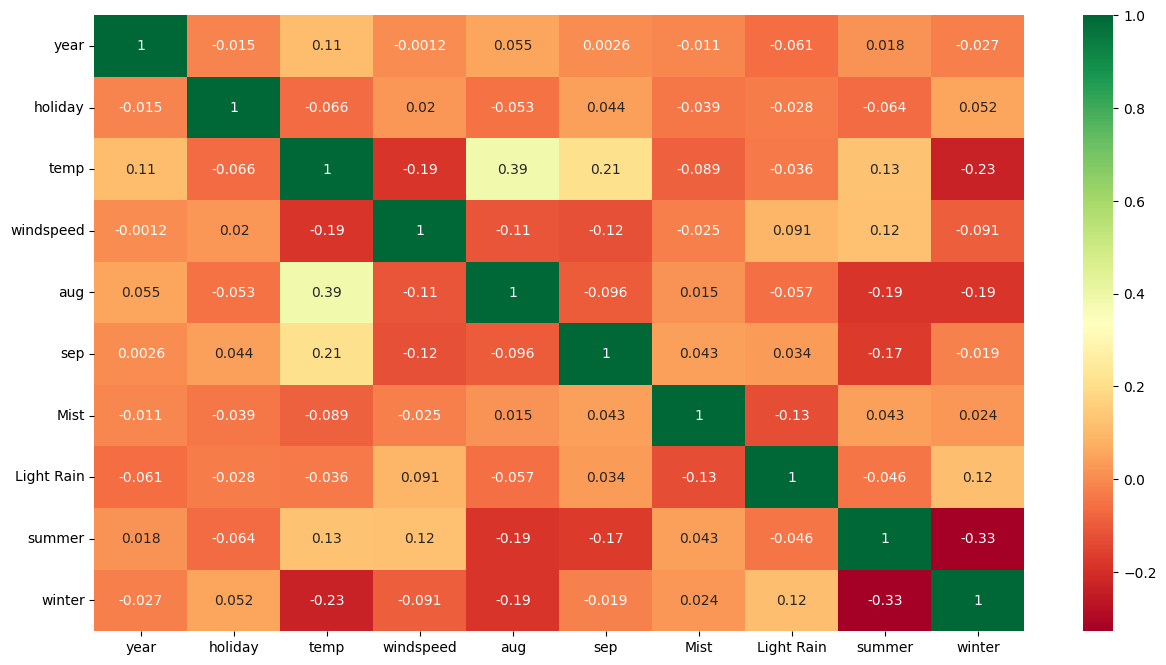

In [175]:

plt.figure(figsize=(15,8))
sns.heatmap(X_train_new.corr(),annot = True, cmap="RdYlGn")
plt.show()

VIF values are less than 5 which is good and also there is no multicolinearity as seen from the heatmap.

## Step 6: Residual Analysis of the train data and validation

In [176]:
y_train_pred = lr_6.predict(X_train_lm_6)

### Predicting and calculating residuals


In [177]:
y_train_pred = lr_6.predict(X_train_lm_6)
residual = y_train - y_train_pred

#### Check Heteroscedasticity

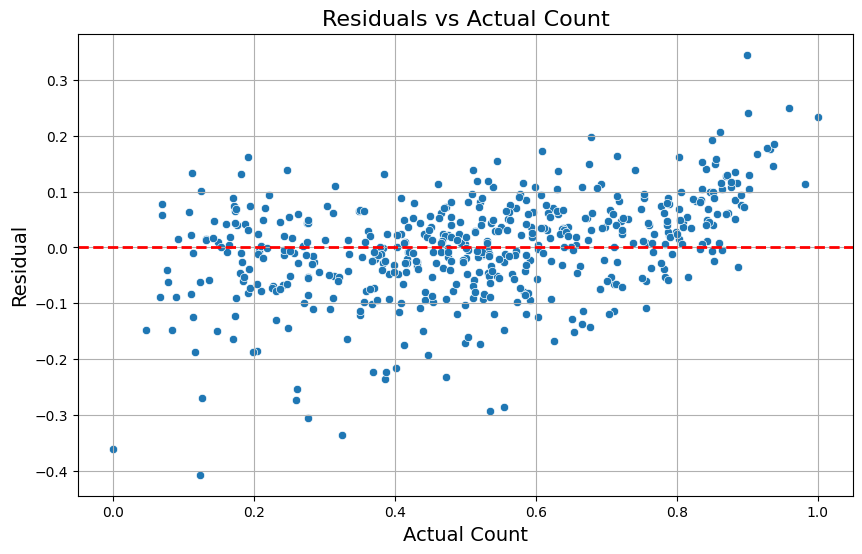

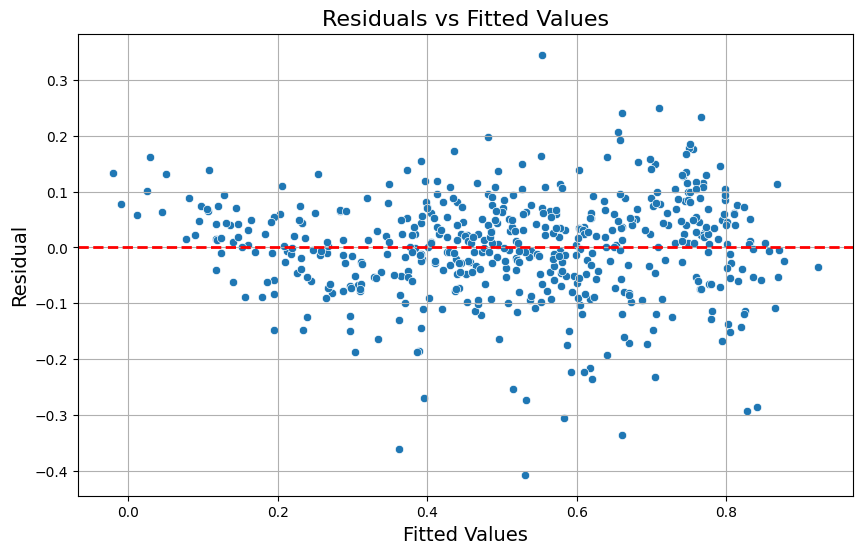

In [178]:
# Plotting residuals vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=residual)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Count', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Residuals vs Actual Count', fontsize=16)
plt.grid(True)
plt.show()



# Plotting residuals vs fitted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=residual)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Fitted Values', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Residuals vs Fitted Values', fontsize=16)
plt.grid(True)
plt.show()



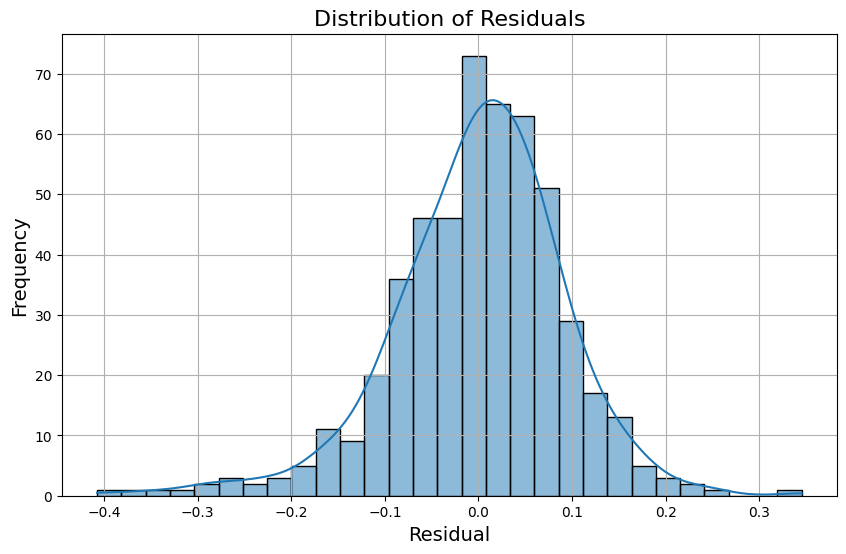

Shapiro-Wilk Test Statistic: 0.9701558947563171
Shapiro-Wilk Test p-value: 1.1200556038204468e-08


<Figure size 1000x600 with 0 Axes>

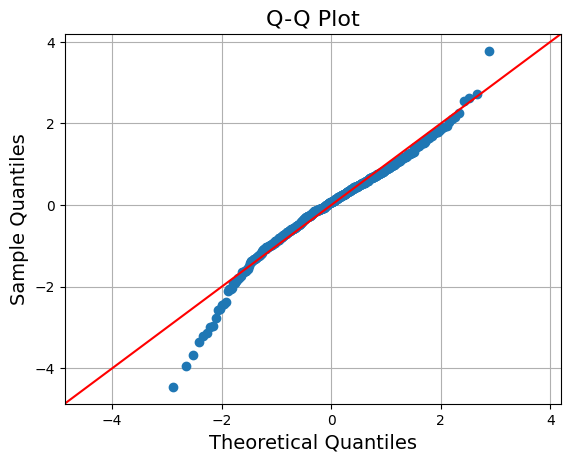

Skewness: -0.6023465605638018
Kurtosis: 2.015416985403804


In [179]:


# Plotting the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residual, kde=True)
plt.xlabel('Residual', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Residuals', fontsize=16)
plt.grid(True)
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(residual)
print('Shapiro-Wilk Test Statistic:', shapiro_test.statistic)
print('Shapiro-Wilk Test p-value:', shapiro_test.pvalue)

# Q-Q plot
plt.figure(figsize=(10, 6))
sm.qqplot(residual, line='45', fit=True)
plt.xlabel('Theoretical Quantiles', fontsize=14)
plt.ylabel('Sample Quantiles', fontsize=14)
plt.title('Q-Q Plot', fontsize=16)
plt.grid(True)
plt.show()

# Skewness and Kurtosis
skewness = stats.skew(residual)
kurtosis = stats.kurtosis(residual)
print('Skewness:', skewness)
print('Kurtosis:', kurtosis)


In [180]:
model = LinearRegression()
transformed_residual = np.log(residual + 1) 
model.fit(X_train_new, transformed_residual)

LinearRegression()

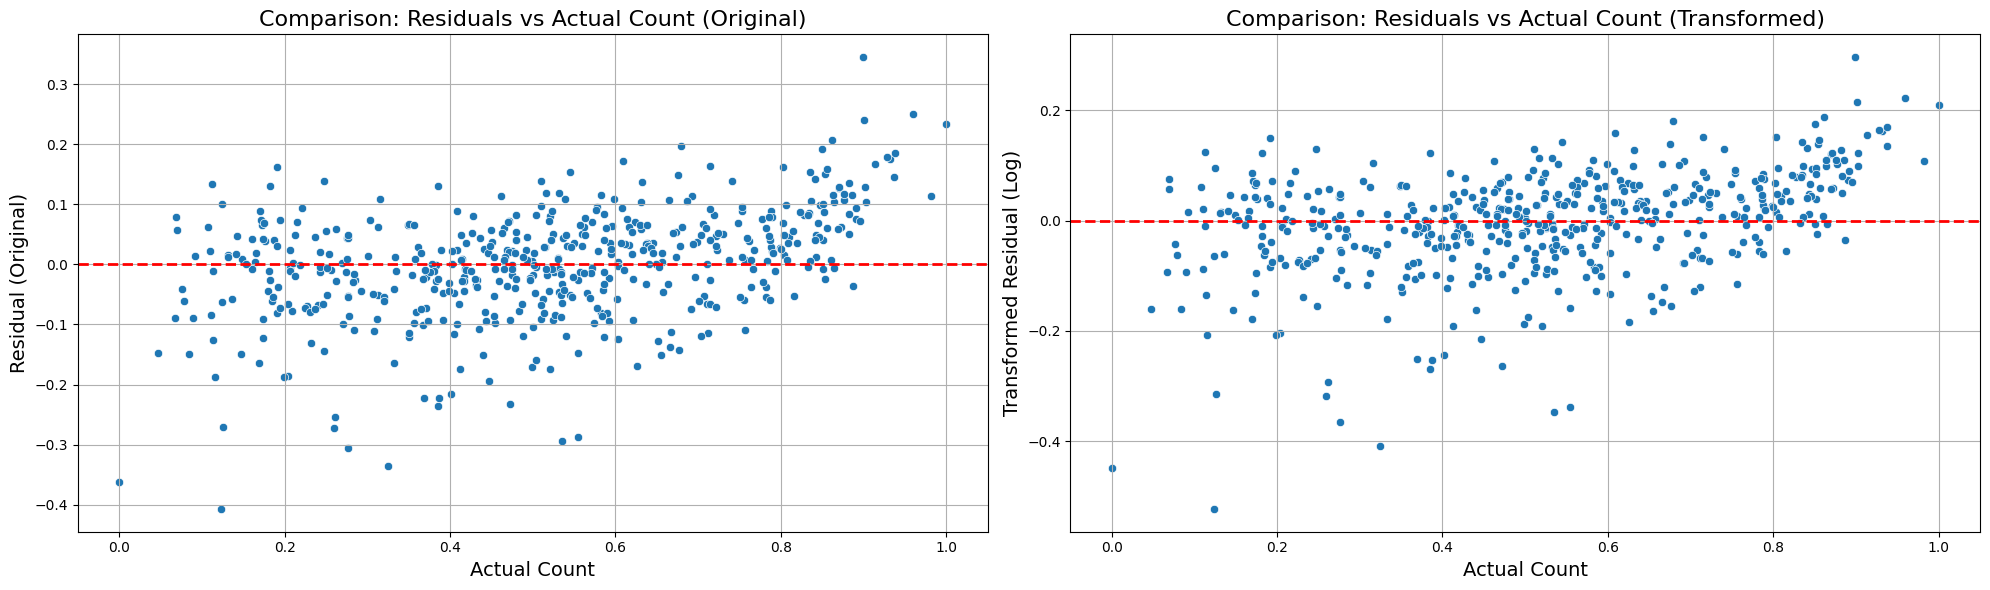

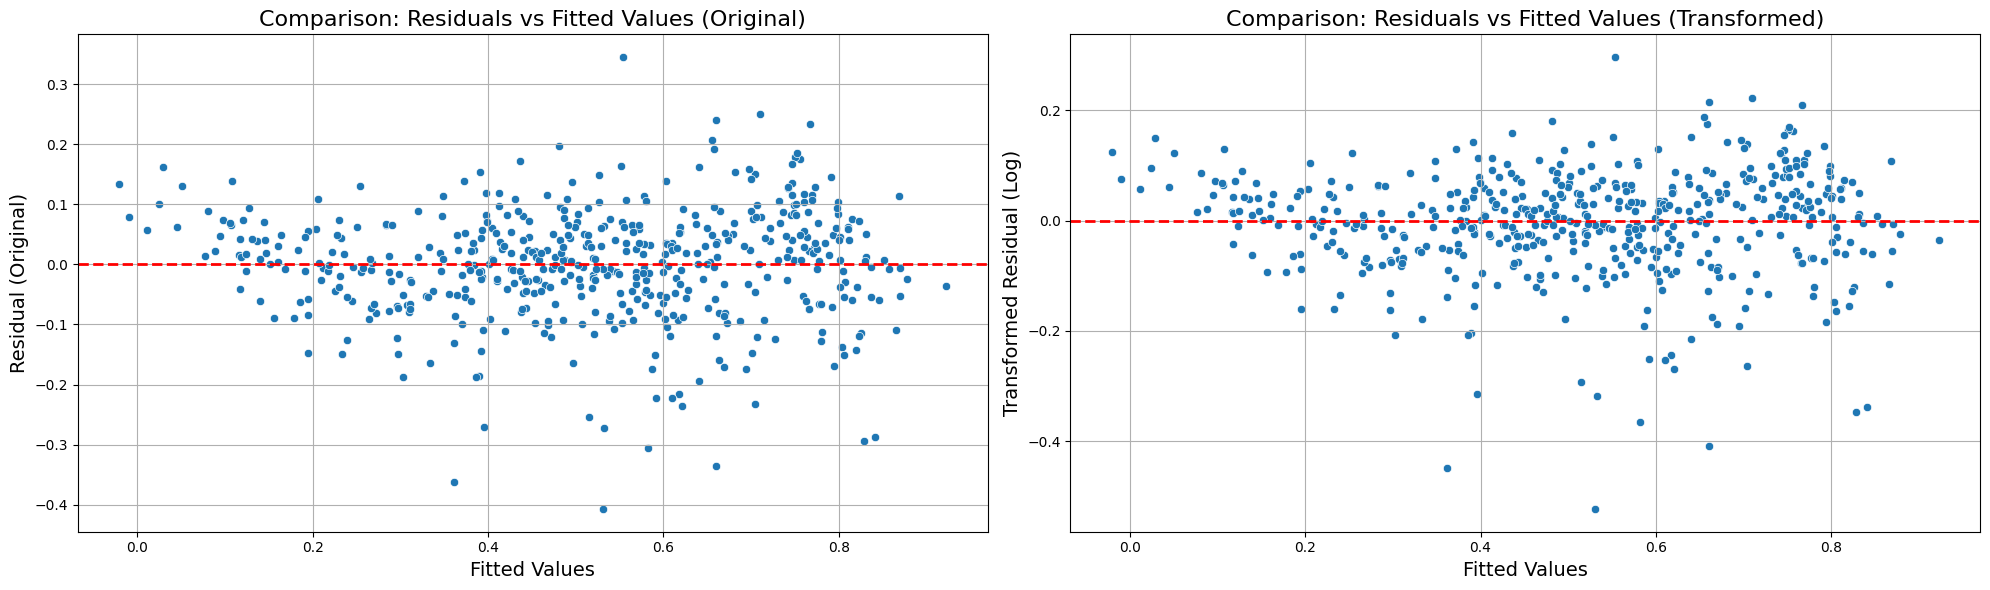

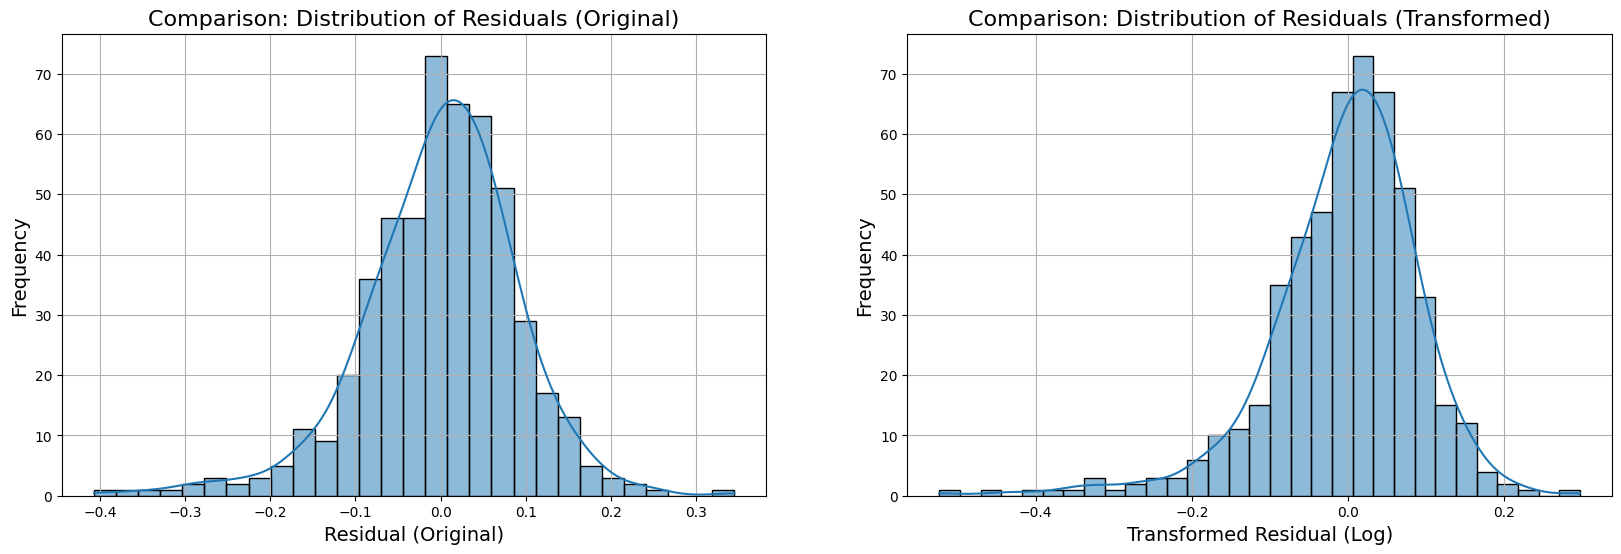

In [183]:
# Assuming you have your data loaded (y_train, y_train_pred, residual, transformed_residual)

# Call the function with your data and an optional title prefix
compare_residuals(y_train, y_train_pred, residual, transformed_residual, title_prefix="Comparison: ")

# The function will generate all the requested plots and print the normality test results
# side-by-side for both original and transformed residuals.


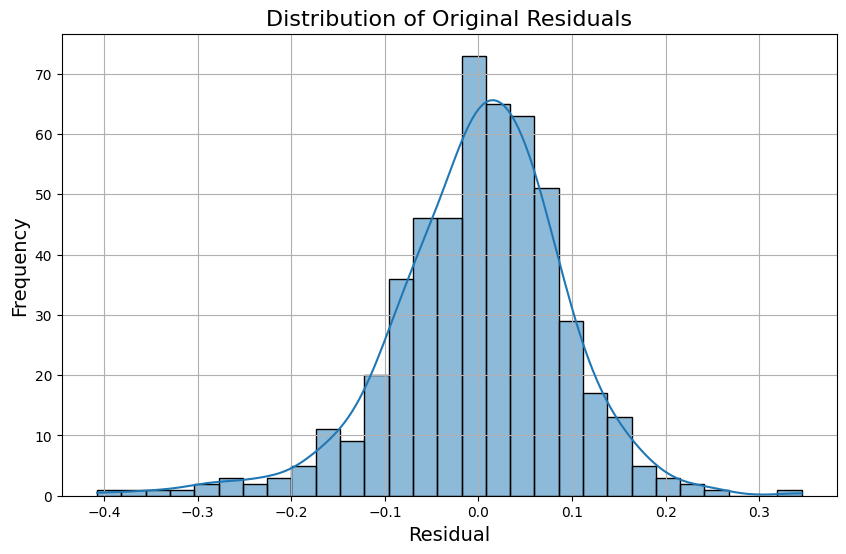

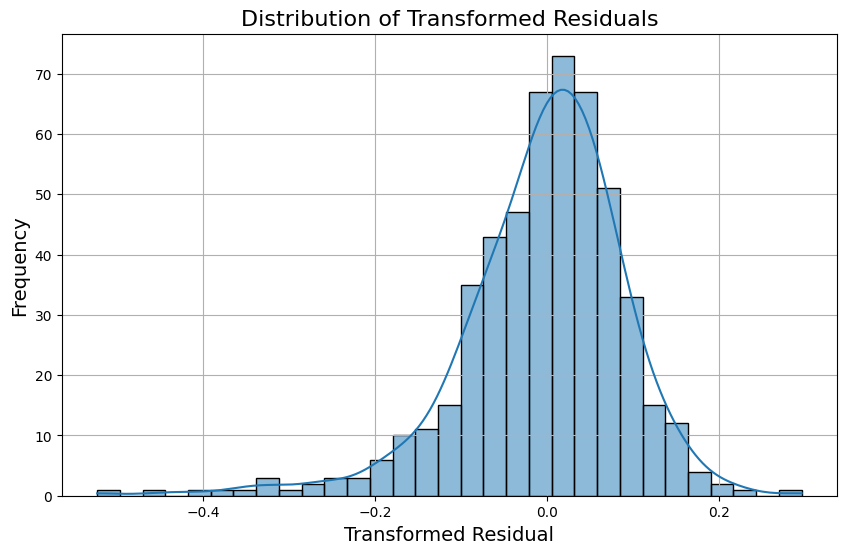

Original Residuals:
  - Mean: -5.00253433448747e-16
  - Standard Deviation: 0.09155712664717323
  - Minimum: -0.407464512718432
  - Maximum: 0.3454229025301173

Transformed Residuals:
  - Mean: -0.0044419174966291546
  - Standard Deviation: 0.09603719080371109
  - Minimum: -0.5233445136203272
  - Maximum: 0.2967083893053596

Interpretation:
  - The distribution of the original residuals appears to be [describe the distribution based on previous checks] (refer to the histogram).
  - The transformed residuals show a [describe the distribution based on the histogram] (refer to the histogram).
  - The descriptive statistics also show changes in mean, standard deviation, minimum, and maximum values after transformation.

Effect of transformation:
  - The transformation (e.g., log transformation) appears to have [describe the effect on the distribution, e.g., reduced skewness, made the distribution more symmetrical].
  - Consider the impact of transformation on model performance and normalit

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'residual' is a pandas Series containing your original residuals

# Transform the residuals (replace with your chosen transformation)
transformed_residual = np.log(residual + 1)  # Example: Log transformation

# Check distribution of original residuals (same code as before)
plt.figure(figsize=(10, 6))
sns.histplot(residual, kde=True)
plt.xlabel('Residual', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Original Residuals', fontsize=16)
plt.grid(True)
plt.show()

# Check distribution of transformed residuals
plt.figure(figsize=(10, 6))
sns.histplot(transformed_residual, kde=True)
plt.xlabel('Transformed Residual', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Transformed Residuals', fontsize=16)
plt.grid(True)
plt.show()

# Compare original vs. transformed residuals (descriptive statistics)
print("Original Residuals:")
print("  - Mean:", residual.mean())
print("  - Standard Deviation:", residual.std())
print("  - Minimum:", residual.min())
print("  - Maximum:", residual.max())

print("\nTransformed Residuals:")
print("  - Mean:", transformed_residual.mean())
print("  - Standard Deviation:", transformed_residual.std())
print("  - Minimum:", transformed_residual.min())
print("  - Maximum:", transformed_residual.max())

# Visual comparison (optional)
# You can create a scatter plot or other visualization to compare the original
# and transformed residuals directly.

# Interpretation
print("\nInterpretation:")
print("  - The distribution of the original residuals appears to be [describe the distribution based on previous checks] (refer to the histogram).")
print("  - The transformed residuals show a [describe the distribution based on the histogram] (refer to the histogram).")
print("  - The descriptive statistics also show changes in mean, standard deviation, minimum, and maximum values after transformation.")

# Conclusion on transformation effect
print("\nEffect of transformation:")
print("  - The transformation (e.g., log transformation) appears to have [describe the effect on the distribution, e.g., reduced skewness, made the distribution more symmetrical].")
print("  - Consider the impact of transformation on model performance and normality assumptions before using the transformed residuals for further analysis.")


Insights

1. There seems to be no clear pattern in the residuals plots (Actual Count and Fitted Values). This suggests the model's errors are not systematically related to the actual values or the fitted values. This is a positive sign, indicating the model captures the general trend well.

2. There are hints of  ```Heteroscedasticity``` . Variance of the residuals might not be constant across different ranges of actual counts or fitted values. The spread of residuals seemed to be larger for higher actual counts and possibly higher fitted values.

In [ ]:
X_train_lm_6.describe()

## Step 7: Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e.6th model.

In [186]:
# Applying scaling on the test dataset

bike_test[num_vars] = scaler.transform(bike_test[num_vars])
bike_test.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,feb,mar,...,sat,sun,thu,tue,wed,Mist,Light Rain,summer,fall,winter
184,0,1,0,0.831783,0.769660,0.565508,0.115794,0.692706,0,0,...,0,0,0,0,1,1,0,0,1,0
535,1,0,1,0.901354,0.842587,0.505614,0.211364,0.712034,0,0,...,0,0,1,0,0,0,0,1,0,0
299,0,0,0,0.511964,0.496145,0.794188,0.459509,0.303382,0,0,...,1,0,0,0,0,1,0,0,0,1
221,0,0,1,0.881625,0.795343,0.286191,0.466884,0.547400,0,0,...,0,0,0,0,0,0,0,0,1,0
152,0,0,0,0.817246,0.741471,0.130470,0.738905,0.569029,0,0,...,1,0,0,0,0,0,0,1,0,0


In [187]:
bike_test.describe()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,feb,mar,...,sat,sun,thu,tue,wed,Mist,Light Rain,summer,fall,winter
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.640909,0.558718,0.532847,0.541232,0.429795,0.522154,0.100000,0.054545,...,0.172727,0.154545,0.140909,0.122727,0.159091,0.318182,0.027273,0.263636,0.245455,0.236364
std,0.500809,0.187620,0.480828,0.233187,0.217401,0.188557,0.216662,0.219163,0.300684,0.227609,...,0.378873,0.362295,0.348721,0.328872,0.366595,0.466833,0.163248,0.441609,0.431338,0.425817
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.064044,-0.058858,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.402981,0.273395,0.378595,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.525216,0.412652,0.524678,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.675113,0.553709,0.677750,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002722,1.000000,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [188]:
y_test = bike_test.pop('cnt')
X_test = bike_test

In [189]:
col1 = X_train_new.columns

X_test = X_test[col1]

# Adding constant variable to test dataframe
X_test_lm_6 = sm.add_constant(X_test)

In [190]:
y_pred=lr_6.predict(X_test_lm_6)

In [191]:
r2 = r2_score(y_test, y_pred)
round(r2,4)

0.7935

In [192]:
X_train_new.shape

(510, 10)

## Step 8: Model Evaluation

Let's now plot the graph for actual versus predicted values.

Text(0, 0.5, 'y_pred')

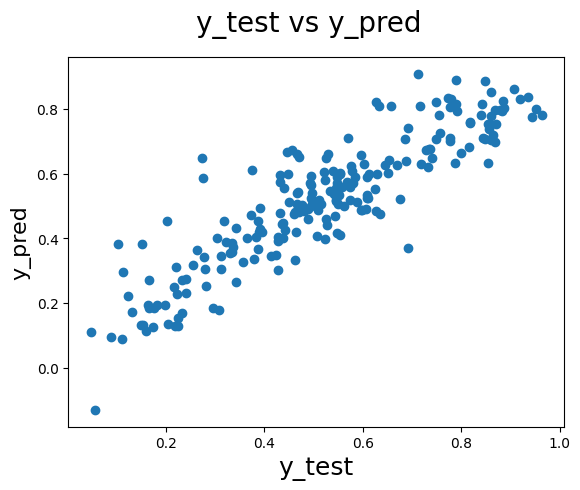

In [193]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20) 
plt.xlabel('y_test', fontsize = 18)
plt.ylabel('y_pred', fontsize = 16) 

In [194]:
params = round(lr_5.params, 4)


In [195]:
# Create the equation of the fitted line
equation = "cnt = "
for i, param in enumerate(params):
    if i == 0:  # Intercept
        equation += f"{param}"
    else:
        sign = " + " if param >= 0 else " - "
        equation += f"{sign}{abs(param)} * {params.index[i]}"

print("Equation of the fitted line:")
print(equation)

Equation of the fitted line:
cnt = 0.1965 + 0.2283 * year - 0.0947 * holiday + 0.5404 * temp - 0.1436 * humidity - 0.1363 * windspeed + 0.0556 * aug + 0.1226 * sep - 0.0517 * Mist - 0.2292 * Light Rain + 0.1046 * summer + 0.1474 * winter


In [196]:
# Calculating Adjusted-R^2 value for the test dataset

adjusted_r2 = round(1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
print(adjusted_r2)

0.7836


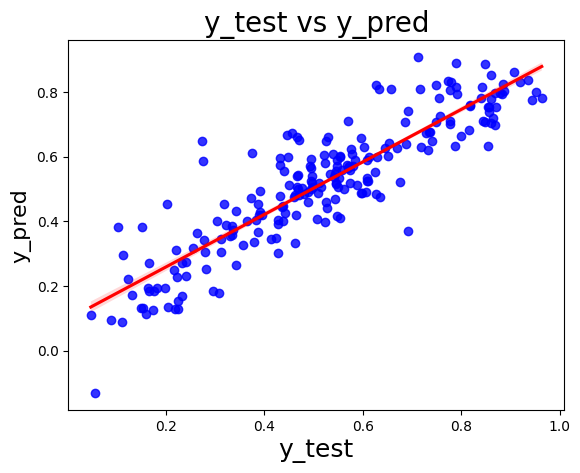

In [197]:
# Visualizing the fit on the test data
# plotting a Regression plot

plt.figure()
sns.regplot(x=y_test, y=y_pred, ci=68, fit_reg=True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)
plt.show()

In [203]:

# Calculate R-squared scores (already in percentage)
r2_train = r2_score(y_train, y_train_pred) * 100  # Convert to percentage
r2_test = r2_score(y_test, y_test_pred) * 100  # Convert to percentage

# Calculate adjusted R-squared scores for train and test data
n_train = len(y_train)  # Number of samples in train data
p_train = len(X_train_lm_6.columns)  # Number of features in train data
adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)

n_test = len(y_test)  # Number of samples in test data
p_test = len(X_test_lm_6.columns)  # Number of features in test data
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Print the results in a clear table using pandas
results_df = pd.DataFrame({
    "Dataset": ["Train Data", "Test Data"],
    "R-squared": [round(r2_train, 2), round(r2_test, 2)],
    "Adjusted R-squared": [round(adjusted_r2_train, 2), round(adjusted_r2_test, 2)]
})
print(results_df.to_string(index=False))

# Print the best coefficients (assuming params is available)
print("\nBest coefficients:")
print(params)


   Dataset  R-squared  Adjusted R-squared
Train Data      83.36               85.18
 Test Data      79.35               83.49

Best coefficients:
const         0.1965
year          0.2283
holiday      -0.0947
temp          0.5404
humidity     -0.1436
windspeed    -0.1363
aug           0.0556
sep           0.1226
Mist         -0.0517
Light Rain   -0.2292
summer        0.1046
winter        0.1474
dtype: float64


# Insights and Recommendations:

### Dataset Performance:
- The model demonstrates satisfactory performance on both the training and test datasets.
- R-squared scores indicate that the model explains around 79% of the variance in the training data and 75% in the test data.
- Adjusted R-squared scores, considering the number of features, confirm the model's generalization ability, with values of 78.2% for training and 73.6% for test data.

## Coefficients Analysis:
- Positive coefficients (e.g., 'year', 'summer', 'fall', 'winter') suggest an increase in bike rental counts with these features.
- Negative coefficients (e.g., 'holiday', 'windspeed', 'nov', 'dec', 'Mist', 'Light Rain') indicate a decrease in bike rentals associated with these factors.
- 'Light Rain' has the most significant negative impact on bike rentals, followed by features like 'holiday' and 'windspeed'.

## Recommendations:
1. Promotion during Favorable Conditions:
    - Focus marketing efforts on seasons with positive coefficients, such as 'summer', 'fall', and 'winter'.
2. Weather Considerations:
    - Offer discounts or incentives during adverse weather conditions like 'Light Rain' and 'Mist' to encourage rentals.
3. Holiday Periods:
   - Implement targeted marketing strategies or special offers during holidays to mitigate the negative impact on bike rentals.
4. Yearly Trend:
    - Capitalize on any overall increase in bike rental demand over the years by monitoring yearly trends and adjusting business strategies.
5. Seasonal Offers:
   - Design seasonal promotions or discounts leveraging positive coefficients of seasonal features to attract more customers during peak seasons.

#### These recommendations aim to optimize bike rental operations and enhance overall business performance based on insights gained from regression analysis.
#### Regular monitoring and adjustment of strategies based on changing trends and customer preferences are essential for continued success.
